In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
from scipy import stats as st

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import visuals as vs

from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

pd.options.display.max_columns = None

import warnings
warnings.simplefilter('ignore')

## Exploring the Data

In [2]:
data = pd.read_csv("data/prosperLoanData_clean.csv")

The data I've imported above is pre-cleaned, and has been previously explored and summarized.  See https://eskrav.github.io/udacity-data-analyst/explore-and-summarize/explore-and-summarize.html, for a full summary of the cleaning process and a visual exploration of the dataset.  

All currently active loans have already been removed from the dataset, as I am interested only in historical loans whose ultimate fate (repayment or default) is already known.  The few loans which were cancelled have been removed from the data, as they do not result in any gain or yield for the lender, and therefore are not of as much interest to the problem at hand, which is helping lenders deciding where to lend their money.

Several new features have already been added to the original data - for example, simple string and numerical binary factors indicating whether the loan was completed or not; a continuous feature indicating what percent of their investment the lenders in fact earned back on the historical loans; and so forth.  Many of these features I will remove early on in this process, as they are redundant with other features, or of no relevance to the task at hand (e.g., they concern information that principally cannot be available to the lender at the time that they are making their decision).

In total, the dataset contains 55084 data points corresponding to individual loans, with 32 continuous and 23 categorical features.  Although the data has already been cleaned, there is still missing data that was not imputed, and non-normally-distributed continuous features which will need to be transformed.  Continuous features will also need to be scaled.

In [3]:
data.sample(10)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating.num,ProsperRating.alpha,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentlyInGroup,GroupKey,DateCreditPulled,CreditScoreRangeLower,CreditScoreRangeUpper,FirstRecordedCreditLine,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeRange,IncomeVerifiable,StatedMonthlyIncome,LoanKey,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanCurrentDaysDelinquent,LoanFirstDefaultedCycleNumber,LoanMonthsSinceOrigination,LoanNumber,LoanOriginalAmount,LoanOriginationDate,LoanOriginationQuarter,MemberKey,MonthlyLoanPayment,LP_CustomerPayments,LP_CustomerPrincipalPayments,LP_InterestandFees,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,PercentYield,Completed,Completed.num,CreditScore,CreditHistoryAge
35324,E9CC336813597613471D6E8,38659,2006-09-11,E,36,Completed,2007-09-21,0.29274,0.2850,0.2550,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,Clerical,Not available,NaN,False,True,18DA336463918236939DCE7,2006-09-11,540.0,559.0,1992-06-11,NaN,NaN,14.0,2,44.0,9.0,24.0,0.0,NaN,6.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15,Not displayed,True,3500.000000,C2B73369064426513FB8C4A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,90,3358,3500,2006-09-20,Q3 2006,CDE0336482731647002E082,145.72,4306.25,3500.00,806.25,-15.51,0.0,0.00,0.00,0.00,1.0,0,0,0.0,43,E,0.225926,Completed,1,549.5,14.260274
19029,CE33338176443792353A2D6,93694,2007-02-05,D,36,Completed,2008-03-03,0.18726,0.1800,0.1700,NaN,NaN,NaN,NaN,NaN,NaN,0,MT,Scientist,Not available,NaN,False,True,C9643379247860156A00EC0,2007-01-31,620.0,639.0,1995-07-12,NaN,NaN,9.0,4,254.0,1.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21,Not displayed,True,2916.666667,FF10338269651751947D672,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,85,7683,10000,2007-02-21,Q1 2007,424133807003981908BD331,361.52,11570.91,10000.00,1570.91,-44.89,0.0,0.00,0.00,0.00,1.0,0,0,0.0,152,D,0.152602,Completed,1,629.5,11.578082
29151,DF2C3398836069751CF3964,191249,2007-08-22,HR,36,Completed,2010-08-30,0.25517,0.2400,0.2300,NaN,NaN,NaN,NaN,NaN,NaN,0,WA,Other,Full-time,16.0,False,False,NaN,2007-07-30,520.0,539.0,1999-12-21,5.0,4.0,19.0,2,30.0,4.0,11.0,7.0,913.0,3.0,1.0,0.0,608.0,0.79,155.0,10.0,0.41,1.0,0.10,"$50,000-74,999",True,4166.666667,538A3399512706410313966,1.0,5.0,4.0,1.0,0.0,3000.0,0.00,-40.0,0,NaN,79,18612,1500,2007-08-30,Q3 2007,78193366362544850377428,30.60,2131.85,1499.92,631.93,-26.34,0.0,0.00,0.00,0.00,1.0,1,1,250.0,14,HR,0.403727,Completed,1,529.5,7.673973
16139,01EB34034846362504B9877,225763,2007-11-04,B,36,Defaulted,2009-01-16,0.16667,0.1595,0.1495,NaN,NaN,NaN,NaN,NaN,NaN,0,IL,Other,Full-time,18.0,False,True,NaN,2007-11-04,700.0,719.0,1994-06-21,14.0,14.0,26.0,13,730.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,34445.0,0.34,66255.0,26.0,1.00,2.0,0.56,"$25,000-49,999",True,3333.333333,C9E0340468271494417FFC0,1.0,9.0,9.0,0.0,0.0,9000.0,7051.63,0.0,671,14.0,76,21695,15000,2007-11-15,Q4 2007,DF9B3374368769016A928A9,526.99,4742.91,3109.16,1633.75,-102.42,0.0,11890.84,11890.84,0.00,1.0,0,0,0.0,285,B,-0.690634,Not Completed,0,709.5,13.380822
51495,860F338072970830381A3A9,93648,2007-02-05,HR,36,Defaulted,2007-08-14,0.21739,0.2100,0.1750

Based on my previous exploration of this data, I am immediately removing those features which are irrelevant to the task at hand, or redundant with other features:

The following are internal loan and borrower identifiers, which are largely redundant with other identifiers, and are of no independent use: `ListingKey`, `ListingNumber`, `LoanKey`, `LoanNumber`, `MemberKey`. Of these, I will keep only `ListingKey` and `MemberKey` for the purposes of identifying individual loans and borrowers, until I have cleaned the data.

The following concern internal group membership, about which there is no further information available (furthermore, most loans do not belong to groups); I will therefore leave these aside for the time being: `CurrentlyInGroup`, `GroupKey`.

The following concern information that is not yet available to the lender at the time they are making the decision of whether to lend money, and therefore cannot serve as a useful feature for the lender, or is not directly informative about whether the loan is closed, or not: `ClosedDate`, `LP_CustomerPayments`, `LP_CustomerPrincipalPayments`, `LP_InterestandFees`, `LP_ServiceFees`, `LP_CollectionFees`, `LP_GrossPrincipalLoss`, `LP_NetPrincipalLoss`, `LP_NonPrincipalRecoverypayments`, `LoanCurrentDaysDelinquent`, `LoanFirstDefaultedCycleNumber`, `LoanMonthsSinceOrigination`, `PercentYield`.

The following are redundant with the `Rating` feature, which combines pre- and post-2009 Prosper rating schemes, as described in the previous data summary: `ProsperRating.num`, `ProsperRating.alpha`, `CreditGrade`.

The following are redundant with the label of interest (`Completed.num`), which indicates whether the loan was repaid in full, or defaulted: `LoanStatus`, `Completed`.  The following are redundant with `CreditScore`, which imputes a single average expected credit score (with minor loss of information): `CreditScoreRangeLower`, `CreditScoreRangeUpper`.  The following is redundant with the loan origination date: `LoanOriginationQuarter`.  The following is redundant with the borrower rate: `BorrowerAPR`.  The following is redundant with monthly income, which as a continuous feature is more easily interpretable: `IncomeRange`.  The following is redundant with age of credit history at the time the loan was originated: `FirstRecordedCreditLine`.

Almost all loans are completely funded (`PercentFunded`).

In [4]:
redundant_irrelevant = ["ListingNumber", "LoanKey", "LoanNumber", "LoanStatus", "ClosedDate",
                       "ProsperRating.num", "ProsperRating.alpha", "CreditScoreRangeLower", "CreditScoreRangeUpper",
                       "LoanOriginationQuarter", "LP_CustomerPayments", "LP_CustomerPrincipalPayments",
                       "LP_InterestandFees", "LP_ServiceFees", "LP_CollectionFees", "LP_GrossPrincipalLoss",
                       "LP_NetPrincipalLoss", "LP_NonPrincipalRecoverypayments", "PercentFunded", "PercentYield",
                       "Completed", "LoanCurrentDaysDelinquent", "LoanFirstDefaultedCycleNumber", 
                       "LoanMonthsSinceOrigination", "BorrowerAPR", "CurrentlyInGroup", "GroupKey", "IncomeRange",
                       "CreditGrade", "FirstRecordedCreditLine"]

data.drop(redundant_irrelevant, axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55084 entries, 0 to 55083
Data columns (total 57 columns):
ListingKey                             55084 non-null object
ListingCreationDate                    55084 non-null object
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                26005 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory.num                    55084 non-null int64
BorrowerState                          49572 non-null object
Occupation                             52819 non-null object
EmploymentStatus                       52832 non-null object
EmploymentStatusDuration               47473 non-null float64
IsBorrowerHomeowner             

First, I convert the dates to continuous timestamps, as the methods I use are not able to handle datetime objects:

In [6]:
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate']).astype(np.int64)
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled']).astype(np.int64)
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate']).astype(np.int64)

Below, I examine features with null values, and infer from existing values if they can/should be imputed (e.g., an `NA` may represent a 0 for some features, if 0's are not generally coded, but would be expected to show up naturally):

In [7]:
data_num_missing = data.isna().sum()
data_num_missing

ListingKey                                 0
ListingCreationDate                        0
Term                                       0
BorrowerRate                               0
LenderYield                                0
EstimatedEffectiveYield                29079
EstimatedLoss                          29079
EstimatedReturn                        29079
ProsperScore                           29079
ListingCategory.num                        0
BorrowerState                           5512
Occupation                              2265
EmploymentStatus                        2252
EmploymentStatusDuration                7611
IsBorrowerHomeowner                        0
DateCreditPulled                           0
CurrentCreditLines                      7600
OpenCreditLines                         7600
TotalCreditLinespast7years               696
OpenRevolvingAccounts                      0
OpenRevolvingMonthlyPayment                0
InquiriesLast6Months                     696
TotalInqui

In [8]:
# percent of data missing per label:
data.isna().mean().round(4) * 100

ListingKey                              0.00
ListingCreationDate                     0.00
Term                                    0.00
BorrowerRate                            0.00
LenderYield                             0.00
EstimatedEffectiveYield                52.79
EstimatedLoss                          52.79
EstimatedReturn                        52.79
ProsperScore                           52.79
ListingCategory.num                     0.00
BorrowerState                          10.01
Occupation                              4.11
EmploymentStatus                        4.09
EmploymentStatusDuration               13.82
IsBorrowerHomeowner                     0.00
DateCreditPulled                        0.00
CurrentCreditLines                     13.80
OpenCreditLines                        13.80
TotalCreditLinespast7years              1.26
OpenRevolvingAccounts                   0.00
OpenRevolvingMonthlyPayment             0.00
InquiriesLast6Months                    1.26
TotalInqui

In [9]:
# value counts for feature of choice
data.TradesOpenedLast6Months.value_counts()

0.0     23139
1.0     13692
2.0      6265
3.0      2540
4.0      1055
5.0       440
6.0       220
7.0        87
8.0        41
9.0        21
11.0       12
10.0       12
12.0        8
13.0        5
14.0        2
17.0        2
15.0        2
20.0        1
Name: TradesOpenedLast6Months, dtype: int64

In [10]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,26005.000000,55084.000000,47473.000000,5.508400e+04,47484.000000,47484.000000,54388.000000,55084.000000,55084.000000,54388.000000,53929.000000,54388.000000,47466.000000,54097.000000,54388.000000,47484.000000,4.748400e+04,47484.000000,47544.000000,47544.000000,47544.000000,47544.000000,50854.000000,55084.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10539.000000,10442.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,54494.000000,54388.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.176231,0.093795,0.107539,6.265987,2.407578,80.895878,1.247556e+18,9.568634,8.337861,25.276164,6.078389,325.307403,2.051850,7.166608,0.906229,1050.814962,4.571658,0.331029,0.023713,1.568936e+04,0.530446,10844.170411,21.786808,0.856399,0.909326,0.289866,5054.723018,1.332764,20.078850,19.486099,0.544074,0.048202,7104.678315,2332.674796,1.146811,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.246247,14.670098
std,6.899523e+16,7.333480,0.081291,0.080726,0.081519,0.055062,0.038377,2.319612,3.397823,84.669661,6.921332e+16,5.582143,4.985417,14.268205,4.528996,448.839320,3.147988,8.214843,2.595972,6676.861621,10.689471,0.790619,0.180400,3.401072e+04,0.350780,21869.026283,12.456163,0.174057,1.240458,0.736738,5711.051112,0.676027,15.871918,15.466862,2.151244,0.509123,6395.297342,3285.130455,50.913387,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.908137,7.554535
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.110600,0.052000,0.078000,5.000000,0.000000,21.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.614000e+03,0.210000,506.000000,13.000000,0.770000,0.000000,0.130000,2810.604167,1.000000,9.000000,9.000000,0.000000,0.000000,3000.000000,0.000000,-32.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.416438
50%,1.219277e+18,36.000000,0.194500,0.182550,0.171500,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,1.000000,15.000000,14.000000,0.000000,0.000000,5000.000000,1098.020000,0.000000,4500.000000,1.220

### Data Imputation

`EstimatedEffectiveYield` was a measure not available prior to mid-2009.  However, it measures the borrower rate minus expected fees, which can be imputed.  Given the data is not normally distributed (which will be examined further below), I will impute missing data with the median difference between borrower rate and estimated effective yield, as implemented in https://www.kaggle.com/jschnessl/prosper-analysis/notebook:

In [11]:
data[data.EstimatedEffectiveYield.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
18368,59403383180727528C28D65,1173225600000000000,36,0.2100,0.1900,NaN,NaN,NaN,NaN,0,MD,Other,Part-time,5.0,False,1172448000000000000,1.0,0.0,3.0,0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,1.00,1.0,0.26,True,916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6250,1174262400000000000,AF423382044830539C3D200,235.47,0,0,0.0,64,C,0,649.5,0.687671
26987,4FD434294793756824EDD32,1218240000000000000,36,0.2200,0.2100,NaN,NaN,NaN,NaN,1,AL,Administrative Assistant,Full-time,313.0,False,1218240000000000000,18.0,16.0,26.0,16,161.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,2774.0,0.05,46776.0,22.0,0.95,4.0,0.25,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1219017600000000000,F5D934274682539049BE93D,76.38,0,0,0.0,16,AA,1,809.5,39.301370
20605,D1C934267431683256BAC7F,1215648000000000000,36,0.1969,0.1869,NaN,NaN,NaN,NaN,1,OK,Accountant/CPA,Full-time,39.0,True,1215648000000000000,13.0,12.0,31.0,5,439.0,8.0,21.0,0.0,0.0,0.0,1.0,0.0,14251.0,0.55,11549.0,27.0,0.96,4.0,0.30,True,4441.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1216944000000000000,66693419508894852078F2F,111.02,0,0,0.0,112,C,1,669.5,18.350685
29180,C33D3366780802161CFFBB4,1156204800000000000,36,0.1795,0.1745,NaN,NaN,NaN,NaN,0,NaN,Administrative Assistant,Not available,NaN,False,1155772800000000000,NaN,NaN,8.0,3,25.0,1.0,2.0,0.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,True,2500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1156982400000000000,AD13336485437292683F4D2,108.38,0,0,0.0,111,E,1,549.5,4.704110
4437,5B5633754332593867AE24C,1165968000000000000,36,0.2300,0.2250,NaN,NaN,NaN,NaN,0,AL,Nurse (RN),Not available,NaN,False,1165968000000000000,NaN,NaN,32.0,6,1062.0,8.0,14.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29,True,5354.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1166659200000000000,3CF23376410097171C677C6,96.77,0,0,0.0,25,E,1,569.5,11.852055


In [12]:
estimated_fees = (data["BorrowerRate"] - data["EstimatedEffectiveYield"]).median()
data["EstimatedEffectiveYield"].fillna(data["BorrowerRate"] - estimated_fees, inplace=True)
data["EstimatedEffectiveYield"].isnull().sum()

0

It's unclear how `EstimatedLoss` is computed.  Given the potential importance of this feature, and the difficulty in imputing it -- as well as the clear dependance on other features, such as risk measures -- I will not attempt to impute this feature, and will look for an algorithm robust to missing values, or simply leave this feature out.  The other potential solution would be to analyze pre-mid-2009 and post-mid-2009 datasets separately.  Ideally, one may want to do linear regression to infer likely values, but that is currently beyond the scope of this project.

In [13]:
data[data.EstimatedLoss.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
5024,F0AA3393736251559604568,1184198400000000000,36,0.2200,0.2100,0.1964,NaN,NaN,NaN,0,NaN,Clerical,Full-time,2.0,False,1184198400000000000,11.0,11.0,14.0,11,612.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,28204.0,0.71,9906.0,14.0,0.92,4.0,0.25000,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1185753600000000000,20633395213008384E3F1AB,572.86,0,0,0.0,149,C,0,669.5,10.035616
516,43D03365506791463BE5D2A,1142208000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1142035200000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13759,True,4250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1142380800000000000,EDAD3365722336384C605F7,94.77,0,0,0.0,12,C,1,NaN,NaN
54280,D1B53364890915697179253,1146355200000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,TX,NaN,NaN,NaN,True,1146355200000000000,NaN,NaN,25.0,0,0.0,1.0,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20361,True,4333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1146787200000000000,E72C33663587416675AEB45,117.31,0,0,0.0,20,E,1,589.5,15.084932
17312,B3023421720279901A79EAB,1212537600000000000,36,0.1385,0.1285,0.1149,NaN,NaN,NaN,3,NC,Other,Full-time,71.0,False,1212537600000000000,5.0,4.0,13.0,5,81.0,1.0,3.0,1.0,0.0,5.0,0.0,0.0,1785.0,0.44,2215.0,10.0,0.60,0.0,0.08000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,1213228800000000000,2E373420153954385544E3F,271.54,0,0,0.0,196,A,1,729.5,18.939726
17007,B6D73425635123336D8FABA,1216339200000000000,36,0.3500,0.3400,0.3264,NaN,NaN,NaN,3,VA,Computer Programmer,Full-time,97.0,True,1216339200000000000,17.0,14.0,74.0,13,674.0,5.0,46.0,0.0,0.0,0.0,0.0,0.0,20536.0,0.84,3618.0,54.0,0.96,2.0,0.29000,True,5166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1217376000000000000,E108339977839820005985A,316.65,0,0,0.0,72,C,0,669.5,11.136986


`EstimatedReturn` is the difference between estimated yield and estimated loss, and cannot be computed without the latter.  I will treat this feature similarly to `EstimatedLoss`.

In [14]:
data[data.EstimatedReturn.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26364,A06C3394620848198203198,1185580800000000000,36,0.2579,0.2479,0.2343,NaN,NaN,NaN,0,AZ,Other,Retired,42.0,False,1184371200000000000,10.0,9.0,36.0,8,173.0,0.0,0.0,1.0,5039.0,26.0,1.0,0.0,4545.0,0.53,3632.0,29.0,0.58,0.0,0.43,True,3291.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16500,1186617600000000000,6E0B339288151722168532F,662.95,1,0,0.0,153,B,0,689.5,14.843836
3360,4FCF3411545136450CC7C80,1202256000000000000,36,0.3100,0.3000,0.2864,NaN,NaN,NaN,1,AL,Clerical,Full-time,89.0,True,1202428800000000000,7.0,6.0,21.0,5,17.0,1.0,4.0,3.0,1575.0,7.0,0.0,0.0,332.0,0.00,4000.0,19.0,0.61,0.0,0.18,True,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1204070400000000000,CF3C3410531845201F327AA,129.00,0,0,0.0,34,D,0,629.5,7.490411
27609,241F3365142212809EB1426,1155772800000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,NaN,Professional,Not available,NaN,True,1155772800000000000,NaN,NaN,15.0,7,166.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.10,True,6166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1156723200000000000,B8A83366686276933842F61,109.68,0,0,0.0,78,AA,1,809.5,10.164384
15024,2DE63390304421824E2ACDE,1181174400000000000,36,0.1800,0.1700,0.1564,NaN,NaN,NaN,0,CO,Executive,Full-time,293.0,True,1180310400000000000,16.0,14.0,60.0,7,2601.0,10.0,29.0,0.0,0.0,0.0,0.0,0.0,187652.0,0.94,9365.0,57.0,1.00,0.0,0.18,True,15416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1181692800000000000,14B533644917274834721CA,903.81,0,0,0.0,233,B,0,689.5,23.912329
46137,66833387333722383CC212B,1177891200000000000,36,0.1274,0.1174,0.1038,NaN,NaN,NaN,0,KS,Military Enlisted,Full-time,19.0,False,1177632000000000000,8.0,6.0,8.0,5,20.0,2.0,8.0,0.0,0.0,0.0,0.0,0.0,197.0,0.00,2206.0,8.0,1.00,3.0,0.26,True,2833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1179100800000000000,1E9E33759967577167C5224,251.77,1,1,50.0,238,B,1,709.5,1.605479


`ProsperScore` is a post-2009 measure.  In my exploratory analysis, it seemed that it might not be entirely redundant with the various Prosper ratings.  I don't believe there is any good way to impute this feature, and will either omit it from the model, or use a model robust to missing values.

In [15]:
data[data.ProsperScore.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
51227,DA7B3415575380154AAA72C,1205798400000000000,36,0.0995,0.0895,0.0759,NaN,NaN,NaN,1,VA,Attorney,Full-time,19.0,True,1204156800000000000,22.0,16.0,35.0,6,920.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,55997.0,0.54,45853.0,35.0,1.00,1.0,0.23,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13250,1206921600000000000,CFFE3415244781073111BE3,427.23,0,0,0.0,250,A,1,729.5,14.553425
1322,29B2339054937261535D144,1181347200000000000,36,0.1550,0.1450,0.1314,NaN,NaN,NaN,0,FL,Analyst,Full-time,77.0,False,1181347200000000000,5.0,3.0,24.0,2,27.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,1390.0,0.73,510.0,5.0,1.00,0.0,0.22,True,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1182211200000000000,2C6D3382063368922BD2B0E,244.37,0,0,0.0,4,D,1,629.5,6.197260
27514,20313415094330107050DE8,1205193600000000000,36,0.1700,0.1600,0.1464,NaN,NaN,NaN,1,AZ,Retail Management,Full-time,10.0,True,1204761600000000000,14.0,13.0,23.0,10,563.0,9.0,24.0,0.0,0.0,0.0,0.0,0.0,46047.0,0.23,21433.0,22.0,0.95,3.0,0.21,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1206403200000000000,BADA340671823260514C050,249.57,0,0,0.0,213,C,1,669.5,9.265753
17539,76C23380045306186F77859,1170201600000000000,36,0.1350,0.1300,0.1114,NaN,NaN,NaN,0,NE,Other,Not available,NaN,True,1170201600000000000,NaN,NaN,22.0,8,941.0,2.0,3.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34,True,3487.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1170892800000000000,94F93378265411970C5ED66,254.51,0,0,0.0,60,B,1,689.5,26.257534
37609,F73E3386490897545D18CD1,1175299200000000000,36,0.2600,0.2400,0.2364,NaN,NaN,NaN,0,NaN,Other,Retired,60.0,False,1174953600000000000,2.0,2.0,9.0,2,40.0,1.0,2.0,2.0,2120.0,7.0,3.0,0.0,505.0,1.01,71.0,6.0,0.83,2.0,0.09,True,1750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1176768000000000000,DA2D33847489497145A48A8,120.91,0,0,0.0,37,E,0,589.5,10.972603


`BorrowerState` cannot be imputed.  Unknown values can be labeled as such; however, given the number of feature levels, and no clear expectations for how this feature will affect reliability, the states may need to be grouped into more meaningful geographical regions or categories prior to use.  I leave this for future work, and remove this label for the time being.

In [16]:
data[data.BorrowerState.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,BorrowerState,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
41001,B1573379535335000FA56B4,1169424000000000000,36,0.2100,0.2050,0.1864,NaN,NaN,NaN,0,NaN,Sales - Commission,Not available,NaN,False,1169424000000000000,NaN,NaN,12.0,5,99.0,2.0,7.0,2.0,NaN,30.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11000,True,3000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6001,1170115200000000000,743C337947809053723BD9E,226.09,0,0,0.0,80,D,0,609.5,11.630137
34604,D4F73365825096264B776C8,1152057600000000000,36,0.1650,0.1550,0.1414,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1152057600000000000,NaN,NaN,22.0,8,304.0,1.0,5.0,0.0,NaN,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07000,True,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2900,1152230400000000000,D6173364824906160400E98,102.67,0,0,0.0,21,C,1,649.5,19.131507
3758,2E0B33647212543356E9E57,1146528000000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,False,1146528000000000000,NaN,NaN,38.0,0,0.0,0.0,NaN,12.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11174,True,2166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1147046400000000000,933A33653534611267AE71A,39.10,0,0,0.0,4,HR,0,489.5,5.906849
35954,37483389786786380482D2D,1180483200000000000,36,0.2090,0.1990,0.1854,NaN,NaN,NaN,0,NaN,Other,Full-time,2.0,False,1179532800000000000,7.0,4.0,8.0,4,98.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,1363.0,1.04,0.0,7.0,1.0,3.0,0.30000,True,1625.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9500,1181779200000000000,CD553389373958426DCC089,357.43,1,0,0.0,176,D,0,609.5,1.479452
36523,427033766045447258A9FE5,1166745600000000000,36,0.2150,0.1950,0.1914,NaN,NaN,NaN,0,NaN,Professional,Not available,NaN,False,1166745600000000000,NaN,NaN,13.0,2,50.0,19.0,31.0,0.0,NaN,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18000,True,8333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1168387200000000000,B8F6337692370532547FD26,568.98,0,0,0.0,261,D,1,609.5,9.230137


In [17]:
data.drop(columns="BorrowerState", axis=1, inplace=True)

`Occupation` cannot be imputed.  Unknown values can be labeled as such, but as with state, known values would need to be grouped meaningfully (e.g. by working class, minimally) to be informative.  I likewise leave this for future work, and for now drop this feature from the dataset.

In [18]:
data[data.Occupation.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
26526,586D3379094071249FC8639,1169769600000000000,36,0.0750,0.0700,0.0514,NaN,NaN,NaN,0,NaN,NaN,NaN,True,1169769600000000000,NaN,NaN,22.0,11,315.0,0.0,9.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06000,True,8333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1170892800000000000,BBC03365612998112329374,155.53,0,0,0.0,133,AA,1,869.5,16.723288
44443,8A3E3365828615294D4F349,1147651200000000000,36,0.1150,0.1062,0.0914,NaN,NaN,NaN,0,NaN,NaN,NaN,True,1147046400000000000,NaN,NaN,38.0,0,0.0,2.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.30000,True,7916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1147824000000000000,2D4B3364525734453AD0F83,164.88,0,0,0.0,14,AA,1,809.5,16.586301
24800,F70F3364692579021FF0A03,1146528000000000000,36,0.1995,0.1895,0.1759,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1146528000000000000,NaN,NaN,7.0,0,0.0,2.0,NaN,2.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11455,True,2600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6727,1147132800000000000,2CAE33661487783579E5184,249.83,0,0,0.0,78,C,1,649.5,9.391781
3147,9D7A33653392733090DDD58,1154563200000000000,36,0.1500,0.1450,0.1264,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1153872000000000000,NaN,NaN,9.0,6,312.0,2.0,6.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20000,True,2375.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4360,1155600000000000000,448433654309212744C9687,151.14,0,0,0.0,97,D,1,629.5,6.736986
22073,DCBB33664336090893F74FF,1145232000000000000,36,0.0950,0.0900,0.0714,NaN,NaN,NaN,0,NaN,NaN,NaN,False,1144022400000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27467,True,2805.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1146182400000000000,A11133653090287242A58B9,81.68,0,0,0.0,20,AA,1,NaN,NaN


In [19]:
data.drop(columns="Occupation", axis=1, inplace=True)

`EmploymentStatus` cannot be imputed.  Unknown values will be labeled as such.

In [20]:
data[data.EmploymentStatus.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
49484,69513366190781272E547DC,1149897600000000000,36,0.1575,0.1525,0.1339,NaN,NaN,NaN,0,NaN,NaN,False,1149897600000000000,NaN,NaN,17.0,7,95.0,1.0,5.0,1.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21000,True,1166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1150761600000000000,4AA333656110559058302C0,105.10,0,0,0.0,17,D,0,629.5,15.709589
46592,2BA63366005379033FA33CA,1152230400000000000,36,0.2875,0.2825,0.2639,NaN,NaN,NaN,0,NaN,NaN,False,1152230400000000000,NaN,NaN,3.0,0,0.0,2.0,10.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1153267200000000000,B08D3365351995435C0A6BD,125.31,0,0,0.0,26,HR,0,489.5,1.205479
3859,3B7A336963132250563D9D3,1158969600000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,NaN,NaN,False,1158537600000000000,NaN,NaN,32.0,1,50.0,1.0,2.0,6.0,NaN,9.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20000,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1159401600000000000,DEC13364582030534B9857A,83.81,0,0,0.0,5,HR,0,509.5,11.915068
528,025233659799100495FDCA5,1140480000000000000,36,0.1000,0.0950,0.0764,NaN,NaN,NaN,0,NaN,NaN,False,1140048000000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07305,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1141171200000000000,2D3933653133392856651DF,95.24,0,0,0.0,30,C,1,NaN,NaN
17830,11273366336093226697543,1150761600000000000,36,0.0670,0.0620,0.0434,NaN,NaN,NaN,0,NaN,NaN,False,1150156800000000000,NaN,NaN,2.0,2,41.0,0.0,1.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.11000,True,666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1151884800000000000,B52C3366072792197E9E00E,30.74,0,0,0.0,22,A,1,729.5,1.936986


In [21]:
data["EmploymentStatus"].fillna("Unknown", inplace=True)
data["EmploymentStatus"].isnull().sum()

0

I will impute `EmploymentStatusDuration` with the median value for this variable.  I would also consider dropping all missing rows, potentially, expecially if there were also missing values in other difficult-to-impute features.  Another possibility, to be explored in the future, is using linear regression to impute these values based on features judged likely to be relevant (e.g., income, occupation, home ownership).  Alternately, an algorithm robust to missing values may be able to handle this data.

In [22]:
data[data.EmploymentStatusDuration.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
2506,2D0633715466530751A60D6,1161820800000000000,36,0.0925,0.0875,0.0689,NaN,NaN,NaN,0,Not available,NaN,False,1161820800000000000,NaN,NaN,20.0,1,15.0,3.0,4.0,6.0,NaN,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03000,True,4099.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2200,1162166400000000000,4E0A33678593302914A0E0F,70.22,0,0,0.0,2,E,1,549.5,19.980822
26062,499E336569919991634CCAE,1147910400000000000,36,0.2375,0.2175,0.2139,NaN,NaN,NaN,0,Unknown,NaN,False,1147910400000000000,NaN,NaN,32.0,0,0.0,2.0,NaN,2.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07000,True,4250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1148515200000000000,2AF83365088180883B5B3ED,141.60,0,0,0.0,39,C,1,669.5,9.967123
13179,67A83366290678162E6028E,1150156800000000000,36,0.1425,0.1350,0.1189,NaN,NaN,NaN,0,Unknown,NaN,False,1149552000000000000,NaN,NaN,9.0,7,280.0,1.0,3.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.38000,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9000,1151020800000000000,D39133651020477085835B5,308.69,0,0,0.0,110,B,1,689.5,7.293151
103,11E23365730062056F90FEB,1152835200000000000,36,0.1775,0.1725,0.1539,NaN,NaN,NaN,0,Unknown,NaN,False,1151452800000000000,NaN,NaN,48.0,2,29.0,1.0,5.0,14.0,NaN,38.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12000,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1153785600000000000,156B3364462532930728CA5,27.61,0,0,0.0,13,E,1,549.5,16.046575
15333,19323366462467845C34094,1142294400000000000,36,0.2200,0.2025,0.1964,NaN,NaN,NaN,0,Unknown,NaN,False,1141689600000000000,NaN,NaN,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.20006,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142899200000000000,D86C3365283627829043C32,114.57,0,0,0.0,16,E,0,NaN,NaN


In [23]:
median_employment_status_duration = data["EmploymentStatusDuration"].median()
data["EmploymentStatusDuration"].fillna(median_employment_status_duration, inplace=True)
data["EmploymentStatusDuration"].isnull().sum()

0

It's unclear what the right course of action here is, but I will impute missing `CurrentCreditLines` with median values.

In [24]:
data[data.CurrentCreditLines.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
33698,06D23380931656206A0FDB7,1170028800000000000,36,0.2200,0.1850,0.1964,NaN,NaN,NaN,0,Not available,52.0,True,1170028800000000000,NaN,NaN,48.0,13,2131.0,27.0,46.0,3.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.54,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1170806400000000000,AEFB3377577781844BB0F7F,95.48,0,0,0.0,42,HR,0,529.5,14.257534
7098,1A0C3379039423509C0EB66,1169856000000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1168387200000000000,NaN,NaN,12.0,0,0.0,8.0,23.0,5.0,NaN,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35,True,2583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2999,1170115200000000000,091E3375420727778E88628,0.00,0,0,0.0,1,HR,0,489.5,4.934247
46361,AD8C33771681655308923D0,1165968000000000000,36,0.0750,0.0700,0.0514,NaN,NaN,NaN,0,Not available,52.0,True,1165363200000000000,NaN,NaN,12.0,3,15.0,0.0,2.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.02,True,5407.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1166659200000000000,BD46337590189749233D10B,93.32,0,0,0.0,32,AA,1,809.5,9.191781
32168,6F02337910919010246E768,1168473600000000000,36,0.2500,0.2450,0.2264,NaN,NaN,NaN,0,Not available,52.0,True,1168473600000000000,NaN,NaN,26.0,15,2865.0,6.0,9.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.31,True,2946.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25000,1169078400000000000,84923379244155021770B39,994.00,0,0,0.0,44,C,0,669.5,16.164384
1592,2A8A33646105071362F7468,1153094400000000000,36,0.1575,0.1375,0.1339,NaN,NaN,NaN,0,Unknown,52.0,True,1153094400000000000,NaN,NaN,18.0,1,0.0,4.0,18.0,5.0,NaN,27.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.01,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1154908800000000000,E8803365085891399E9EBA2,38.87,0,0,0.0,14,D,1,629.5,21.057534


In [25]:
median_credit_lines = data["CurrentCreditLines"].median()
data["CurrentCreditLines"].fillna(median_credit_lines, inplace=True)
data["CurrentCreditLines"].isnull().sum()

0

Same for `OpenCreditLines`.

In [26]:
data[data.OpenCreditLines.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
52814,267F3365059839076C8B034,1150416000000000000,36,0.0925,0.0875,0.0689,NaN,NaN,NaN,0,Unknown,52.0,True,1150416000000000000,9.0,NaN,10.0,5,300.0,6.0,7.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4200,1151366400000000000,D8F53365800079472C58DAC,134.05,0,0,0.0,147,A,1,729.5,11.186301
2967,9C4133644740985703E98E1,1150761600000000000,36,0.1800,0.1750,0.1564,NaN,NaN,NaN,0,Unknown,52.0,True,1150761600000000000,9.0,NaN,24.0,2,0.0,1.0,3.0,4.0,NaN,10.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1152057600000000000,CFE33365630751711594B58,271.14,0,0,0.0,51,B,0,689.5,18.731507
7182,EAB833651562287128161B0,1155081600000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,True,1155081600000000000,9.0,NaN,24.0,4,75.0,2.0,5.0,0.0,NaN,6.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.16,True,6250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1155513600000000000,C8D63365958828093600794,185.82,0,0,0.0,34,C,1,649.5,20.964384
3079,9D29336564132638249E502,1156291200000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,Not available,52.0,False,1156204800000000000,9.0,NaN,8.0,4,126.0,2.0,6.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.34,True,1260.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1157414400000000000,6B02336634830867603869E,89.13,0,0,0.0,19,D,0,629.5,7.556164
6508,D58933739073094760C0C9F,1164499200000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Not available,52.0,False,1163376000000000000,9.0,NaN,28.0,3,35.0,2.0,10.0,10.0,NaN,70.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.49,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1100,1165795200000000000,C1133373047639234D19382,40.88,0,0,0.0,34,HR,1,529.5,10.180822


In [27]:
median_open_credit_lines = data["OpenCreditLines"].median()
data["OpenCreditLines"].fillna(median_open_credit_lines, inplace=True)
data["OpenCreditLines"].isnull().sum()

0

Same for `TotalCreditLinespast7years`.

In [28]:
data[data.TotalCreditLinespast7years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50194,B7C9336526252127503737D,1143936000000000000,36,0.0900,0.0850,0.0664,NaN,NaN,NaN,0,Unknown,52.0,False,1142640000000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15778,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1144886400000000000,6E6E336508740831615F30D,95.43,0,0,0.0,30,A,1,NaN,NaN
20310,4D0B3366446297449DC04A1,1144972800000000000,36,0.1000,0.0950,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1144540800000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1145836800000000000,2F293365179465347C776FD,48.40,0,0,0.0,20,NC,1,NaN,NaN
4717,9A5B33657249119794C3EA6,1142985600000000000,36,0.3295,0.3245,0.3059,NaN,NaN,NaN,0,Unknown,52.0,False,1141862400000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35155,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2800,1143504000000000000,898433654667427770D7E1F,123.43,0,0,0.0,34,NC,0,NaN,NaN
22073,DCBB33664336090893F74FF,1145232000000000000,36,0.0950,0.0900,0.0714,NaN,NaN,NaN,0,Unknown,52.0,False,1144022400000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.27467,True,2805.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1146182400000000000,A11133653090287242A58B9,81.68,0,0,0.0,20,AA,1,NaN,NaN
29960,72E633648635926820B2B34,1144627200000000000,36,0.2370,0.2070,0.2134,NaN,NaN,NaN,0,Unknown,52.0,False,1144368000000000000,9.0,8.0,NaN,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07003,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1145491200000000000,95163364478495257A20993,136.76,0,0,0.0,29,E,0,NaN,NaN


In [29]:
median_7_credit_lines = data["TotalCreditLinespast7years"].median()
data["TotalCreditLinespast7years"].fillna(median_7_credit_lines, inplace=True)
data["TotalCreditLinespast7years"].isnull().sum()

0

I will impute missing values in `InquiriesLast6Months` with median values.

In [30]:
data[data.InquiriesLast6Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
528,025233659799100495FDCA5,1140480000000000000,36,0.1000,0.0950,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1140048000000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07305,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1141171200000000000,2D3933653133392856651DF,95.24,0,0,0.0,30,C,1,NaN,NaN
53962,B4F6337744905877323E37A,1168128000000000000,36,0.2900,0.2550,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1168128000000000000,9.0,8.0,23.0,0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3002,1169510400000000000,D1E33379320424585DE0BCC,125.80,0,0,0.0,27,NC,0,9.5,NaN
23133,3352336558458503468C434,1144108800000000000,36,0.1475,0.1375,0.1239,NaN,NaN,NaN,0,Unknown,52.0,False,1143504000000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.06418,True,1791.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2750,1144800000000000000,5D013364817021486364680,93.50,0,0,0.0,23,C,1,NaN,NaN
41000,B1573365763794805290A8E,1142208000000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Unknown,52.0,False,1142208000000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.18744,True,1684.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1143072000000000000,F6373365091150549059825,188.02,0,0,0.0,44,AA,1,NaN,NaN
1610,42083366023268939EBC25E,1141689600000000000,36,0.1500,0.1300,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,23.0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12720,True,2083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1142380800000000000,B906336475417750338C047,104.00,0,0,0.0,17,D,0,NaN,NaN


In [31]:
median_inquiries = data["InquiriesLast6Months"].median()
data["InquiriesLast6Months"].fillna(median_inquiries, inplace=True)
data["InquiriesLast6Months"].isnull().sum()

0

I will impute missing values in `TotalInquiries` with median values.

In [32]:
data[data.TotalInquiries.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
18987,7BD533658610252386B8ACE,1141776000000000000,36,0.3125,0.2950,0.2889,NaN,NaN,NaN,0,Unknown,52.0,False,1140739200000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07768,True,9166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2900,1142208000000000000,921733657315948546FCE59,125.10,0,0,0.0,16,HR,0,NaN,NaN
15209,17AD3366304320388B363C3,1148860800000000000,36,0.1575,0.1400,0.1339,NaN,NaN,NaN,0,Unknown,52.0,False,1148860800000000000,9.0,8.0,24.0,0,0.0,3.0,NaN,0.0,NaN,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21000,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1150156800000000000,EA20336508791152643B7CD,70.07,0,0,0.0,10,E,1,589.5,15.235616
7206,3FE43365786463102BFC52A,1143158400000000000,36,0.1090,0.1040,0.0854,NaN,NaN,NaN,0,Unknown,52.0,False,1143158400000000000,9.0,8.0,23.0,0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13754,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1144627200000000000,F2643365335203849A84267,163.46,0,0,0.0,86,B,0,NaN,NaN
24995,5ED533651242806240D92CD,1145404800000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,True,1145404800000000000,9.0,8.0,35.0,0,0.0,6.0,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13133,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1145923200000000000,A103336616312913438396C,117.31,0,0,0.0,33,E,0,549.5,15.531507
18009,C7453365137655778B5D141,1148860800000000000,36,0.2475,0.2425,0.2239,NaN,NaN,NaN,0,Unknown,52.0,True,1148860800000000000,9.0,8.0,5.0,0,0.0,4.0,NaN,2.0,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,1149465600000000000,06373365101484238638E47,103.03,0,0,0.0,18,HR,0,449.5,7.205479


In [33]:
median_total_inquiries = data["TotalInquiries"].median()
data["TotalInquiries"].fillna(median_total_inquiries, inplace=True)
data["TotalInquiries"].isnull().sum()

0

I will impute missing values in `CurrentDelinquencies` with median values.

In [34]:
data[data.CurrentDelinquencies.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
46351,B1F83372115964759971BCA,1161216000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1161216000000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1600.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3800,1162512000000000000,CF4D3368051571437944E1F,159.24,0,0,0.0,11,HR,0,9.5,NaN
44580,70DA33661475901191E9B6E,1151020800000000000,36,0.2075,0.2025,0.1839,NaN,NaN,NaN,0,Unknown,52.0,False,1149465600000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1151452800000000000,6CD2336549242523002F83D,37.55,0,0,0.0,11,NC,1,9.5,NaN
7582,E0433364514200051476E13,1139616000000000000,36,0.1825,0.1650,0.1589,NaN,NaN,NaN,0,Unknown,52.0,False,1138492800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08410,True,3750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8500,1140480000000000000,2694336512301362982F84B,308.36,0,0,0.0,12,HR,0,NaN,NaN
33329,CC3D33646727409925A7492,1144800000000000000,36,0.1775,0.1650,0.1539,NaN,NaN,NaN,0,Unknown,52.0,False,1144368000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.22247,True,1875.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1145836800000000000,68EF33654424946958B48E3,180.14,0,0,0.0,34,D,1,NaN,NaN
24014,6FFF3365204947817232689,1141084800000000000,36,0.2300,0.2125,0.2064,NaN,NaN,NaN,0,Unknown,52.0,False,1140134400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03573,True,1083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1141603200000000000,AB383365732096538B1F8B5,38.71,0,0,0.0,9,HR,1,NaN,NaN


In [35]:
median_delinquencies = data["CurrentDelinquencies"].median()
data["CurrentDelinquencies"].fillna(median_delinquencies, inplace=True)
data["CurrentDelinquencies"].isnull().sum()

0

I will impute missing values in `AmountDelinquent` with median values.

In [36]:
data[data.AmountDelinquent.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
17937,A0483377621548762E97330,1168560000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1168214400000000000,9.0,8.0,22.0,0,0.0,3.0,5.0,9.0,NaN,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,1400.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1168992000000000000,7EC33374025342758894FA0,62.86,0,0,0.0,14,HR,0,509.5,4.591781
22043,5CDE3364356452346DB5DD2,1149033600000000000,36,0.2800,0.2450,0.2564,NaN,NaN,NaN,0,Unknown,52.0,False,1149033600000000000,9.0,8.0,21.0,4,146.0,5.0,14.0,6.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.08000,True,3780.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15000,1150675200000000000,CF1C3366401267412A3647D,620.45,0,0,0.0,58,D,1,629.5,13.794521
23984,9F4A336893609429620221A,1158192000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1157760000000000000,9.0,8.0,6.0,0,0.0,9.0,11.0,5.0,NaN,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07000,True,1666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2600,1158710400000000000,BC12336855863653434ECD4,108.95,0,0,0.0,19,HR,0,469.5,6.367123
18719,D73133754076108065D788C,1164758400000000000,36,0.2250,0.2200,0.2014,NaN,NaN,NaN,0,Not available,52.0,True,1164758400000000000,9.0,8.0,26.0,6,258.0,1.0,11.0,1.0,NaN,24.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.14000,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1165449600000000000,AF093375865762086664567,190.47,0,0,0.0,49,C,1,649.5,11.986301
43204,F4CA336452312492265674A,1146787200000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1146787200000000000,9.0,8.0,27.0,0,0.0,16.0,5.0,0.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.15253,True,10166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1147305600000000000,4FF333657248389409B9895,273.71,0,0,0.0,63,E,0,589.5,8.649315


In [37]:
median_amount_delinquent = data["AmountDelinquent"].median()
data["AmountDelinquent"].fillna(median_amount_delinquent, inplace=True)
data["AmountDelinquent"].isnull().sum()

0

I will impute missing values in `DelinquenciesLast7Years` with median values.

In [38]:
data[data.DelinquenciesLast7Years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39010,DF2D33646503761044BC574,1146614400000000000,36,0.2375,0.2325,0.2139,NaN,NaN,NaN,0,Unknown,52.0,False,1146614400000000000,9.0,8.0,66.0,0,0.0,8.0,5.0,6.0,0.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.13774,True,9825.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1147219200000000000,446233648398105201B51B9,117.34,0,0,0.0,29,E,0,549.5,10.542466
4911,4349337812930528585C07F,1167696000000000000,36,0.0700,0.0650,0.0464,NaN,NaN,NaN,0,Not available,52.0,False,1166659200000000000,9.0,8.0,23.0,1,10.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,868.833333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1169164800000000000,40DA33678705733672637E3,30.88,0,0,0.0,7,HR,0,509.5,NaN
42086,5B083365639321850399289,1147564800000000000,36,0.0982,0.0920,0.0746,NaN,NaN,NaN,0,Unknown,52.0,False,1147305600000000000,9.0,8.0,21.0,0,0.0,1.0,5.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.35000,True,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1148601600000000000,D39433644594319425D0514,160.91,0,0,0.0,40,A,1,749.5,5.704110
51438,B8D63366141679436131B1C,1132444800000000000,36,0.0900,0.0850,0.0664,NaN,NaN,NaN,0,Unknown,52.0,False,1131494400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03826,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4800,1132876800000000000,ED983364564478611B1273E,152.64,0,0,0.0,1,NC,1,NaN,NaN
53803,B28833649406229450AD983,1143936000000000000,36,0.2200,0.2150,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1143936000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.21018,True,3416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3800,1144972800000000000,C7703366385739280063FBA,141.66,0,0,0.0,48,D,1,NaN,NaN


In [39]:
median_7_delinquencies = data["DelinquenciesLast7Years"].median()
data["DelinquenciesLast7Years"].fillna(median_7_delinquencies, inplace=True)
data["DelinquenciesLast7Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast10Years` with median values.

In [40]:
data[data.PublicRecordsLast10Years.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
9088,F657337785415518867729F,1167696000000000000,36,0.290,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1167436800000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2080.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1200,1168905600000000000,BED5337791114687563AFB9,50.29,0,0,0.0,15,NC,0,9.5,NaN
40352,64553365458415962B4FF37,1144713600000000000,36,0.100,0.0925,0.0764,NaN,NaN,NaN,0,Unknown,52.0,False,1144368000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.09973,True,6083.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1145404800000000000,17DE3366459561336980309,322.67,0,0,0.0,119,AA,0,NaN,NaN
9914,512D336605645920233DDEB,1143417600000000000,36,0.114,0.1090,0.0904,NaN,NaN,NaN,0,Unknown,52.0,False,1143417600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05030,True,10000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1144022400000000000,7A733364719374158FA0FAC,83.97,0,0,0.0,63,C,1,NaN,NaN
33276,BF1633664001758477BFAA6,1140912000000000000,36,0.120,0.1150,0.0964,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.43886,True,2375.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3200,1141257600000000000,66F733654763601129B7B05,104.46,0,0,0.0,18,A,1,NaN,NaN
9516,4B183368381941574321973,1158710400000000000,36,0.290,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1158710400000000000,9.0,8.0,23.0,0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,1500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1300,1159315200000000000,7EB63369219545679067616,54.48,0,0,0.0,20,NC,1,9.5,NaN


In [41]:
median_10_public_records = data["PublicRecordsLast10Years"].median()
data["PublicRecordsLast10Years"].fillna(median_10_public_records, inplace=True)
data["PublicRecordsLast10Years"].isnull().sum()

0

I will impute missing values in `PublicRecordsLast12Months` with median values.

In [42]:
data[data.PublicRecordsLast12Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
27991,FBBD337303875940576631D,1163030400000000000,36,0.0900,0.0850,0.0664,NaN,NaN,NaN,0,Not available,52.0,False,1163030400000000000,9.0,8.0,24.0,7,809.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.24,True,7500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4500,1164585600000000000,BC843372594980246EBE3A2,143.10,0,0,0.0,60,A,1,749.5,17.200000
13366,79DE3365218484837E4955F,1152403200000000000,36,0.2475,0.2425,0.2239,NaN,NaN,NaN,0,Not available,52.0,True,1152057600000000000,9.0,8.0,28.0,2,16.0,3.0,18.0,2.0,0.0,26.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.07,True,6066.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4790,1152835200000000000,BB5C3365703890910C7F860,182.09,0,0,0.0,48,HR,1,529.5,16.104110
27777,C66233653015555878FBC23,1154304000000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1153267200000000000,9.0,8.0,7.0,1,20.0,6.0,27.0,4.0,0.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,True,4000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1155081600000000000,7D733364412540411E2FD44,104.76,0,0,0.0,26,HR,0,469.5,5.605479
1499,953E33797507561979625B4,1169251200000000000,36,0.1894,0.1844,0.1658,NaN,NaN,NaN,0,Not available,52.0,False,1169251200000000000,9.0,8.0,10.0,5,1104.0,0.0,5.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.75,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20000,1170201600000000000,F60F3380208913236743584,732.51,0,0,0.0,205,A,1,729.5,14.731507
18275,665F3366305638345F29FE3,1149033600000000000,36,0.2000,0.1950,0.1764,NaN,NaN,NaN,0,Unknown,52.0,False,1149033600000000000,9.0,8.0,17.0,6,54.0,2.0,3.0,2.0,0.0,34.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.17,True,2750.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1150156800000000000,1F56336598915408995EAE4,48.48,0,0,0.0,17,HR,1,529.5,14.589041


In [43]:
median_public_records_12 = data["PublicRecordsLast12Months"].median()
data["PublicRecordsLast12Months"].fillna(median_public_records_12, inplace=True)
data["PublicRecordsLast12Months"].isnull().sum()

0

I will impute missing values in `RevolvingCreditBalance` with median values.

In [44]:
data[data.RevolvingCreditBalance.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
54331,F5B23365741233226573D3C,1152662400000000000,36,0.1915,0.1865,0.1679,NaN,NaN,NaN,0,Not available,52.0,False,1152662400000000000,9.0,8.0,6.0,1,0.0,3.0,5.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.30,True,3755.583333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1153180800000000000,A8993365215165848CB2CFF,35.61,0,0,0.0,16,D,1,629.5,24.071233
50996,D1C533714976917895A23A5,1161734400000000000,36,0.2800,0.2750,0.2564,NaN,NaN,NaN,0,Not available,52.0,True,1161302400000000000,9.0,8.0,21.0,2,15.0,6.0,10.0,7.0,0.0,23.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.16,True,3941.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1162252800000000000,ED8B33725393561364238E9,124.09,0,0,0.0,25,E,0,549.5,23.071233
35669,D15D3368830160104798C12,1159488000000000000,36,0.1275,0.1200,0.1039,NaN,NaN,NaN,0,Not available,52.0,True,1159488000000000000,9.0,8.0,28.0,8,2021.0,9.0,14.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.75,True,4583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1160524800000000000,7F943370383350938772E84,167.87,0,0,0.0,96,A,1,729.5,21.156164
11230,B8413374424010171177EEF,1165276800000000000,36,0.1300,0.1200,0.1064,NaN,NaN,NaN,0,Not available,52.0,True,1165104000000000000,9.0,8.0,35.0,2,0.0,0.0,6.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.31,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6500,1165968000000000000,6CC13374805211908AA39FD,167.32,0,0,0.0,58,AA,1,769.5,18.279452
16008,A21F33789884797646E905E,1168560000000000000,36,0.2100,0.2050,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1168560000000000000,9.0,8.0,10.0,6,292.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.55,True,4250.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1169164800000000000,788C3376907948358C4044E,113.03,0,0,0.0,31,D,1,609.5,6.087671


In [45]:
median_revolving_credit = data["RevolvingCreditBalance"].median()
data["RevolvingCreditBalance"].fillna(median_revolving_credit, inplace=True)
data["RevolvingCreditBalance"].isnull().sum()

0

I will impute missing values in `BankcardUtilization` with median values.

In [46]:
data[data.BankcardUtilization.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
42330,5D283370847352863DB84F6,1160265600000000000,36,0.1925,0.1750,0.1689,NaN,NaN,NaN,0,Not available,52.0,False,1158883200000000000,9.0,8.0,7.0,1,15.0,1.0,3.0,0.0,0.0,11.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.17000,True,2833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2550,1161043200000000000,B7B93368976097801EB85F1,93.80,0,0,0.0,54,E,1,549.5,6.591781
43984,F99933654053201772AA581,1153699200000000000,36,0.2743,0.2693,0.2507,NaN,NaN,NaN,0,Unknown,52.0,False,1153699200000000000,9.0,8.0,16.0,0,0.0,4.0,25.0,13.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.15000,True,2666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1154304000000000000,2C103365745283524A85E47,123.17,0,0,0.0,39,E,0,549.5,7.852055
53068,578E33807399734321EBB57,1170806400000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Not available,52.0,False,1170374400000000000,9.0,8.0,31.0,15,275.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.08000,True,5516.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1171929600000000000,17593380154990551EFD3F7,156.68,0,0,0.0,53,AA,1,769.5,31.627397
18111,8F643366017487936B6D1F3,1141862400000000000,36,0.1350,0.1300,0.1114,NaN,NaN,NaN,0,Unknown,52.0,False,1141171200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.06885,True,12500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1142985600000000000,32D93365236061390461EEA,169.68,0,0,0.0,38,C,0,NaN,NaN
11776,FC963364670928021B9383F,1153612800000000000,36,0.2150,0.2050,0.1914,NaN,NaN,NaN,0,Unknown,52.0,True,1153612800000000000,9.0,8.0,20.0,3,133.0,0.0,2.0,4.0,0.0,3.0,0.0,0.0,6073.0,NaN,NaN,NaN,NaN,NaN,0.67000,True,1000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10001,1154649600000000000,B8A03365820668672BC1459,379.36,0,0,0.0,67,C,0,669.5,15.567123


In [47]:
median_bankcard_utilization = data["BankcardUtilization"].median()
data["BankcardUtilization"].fillna(median_bankcard_utilization, inplace=True)
data["BankcardUtilization"].isnull().sum()

0

I will impute missing values in `AvailableBankcardCredit` with median values.

In [48]:
data[data.AvailableBankcardCredit.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
41474,59FF3364840893588232718,1154563200000000000,36,0.150,0.1450,0.1264,NaN,NaN,NaN,0,Not available,52.0,True,1153958400000000000,9.0,8.0,51.0,16,3649.0,6.0,20.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.23,True,20833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1154995200000000000,980133653327859923211C8,104.00,0,0,0.0,12,C,0,669.5,13.942466
35359,A8473367119913105B7AFC4,1156550400000000000,36,0.280,0.2750,0.2564,NaN,NaN,NaN,0,Not available,52.0,False,1156118400000000000,9.0,8.0,8.0,2,23.0,2.0,3.0,5.0,0.0,5.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.13,True,5000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4000,1156809600000000000,20BA3365982285871633AE4,165.45,0,0,0.0,37,E,0,589.5,6.484932
47174,261C33644368772102354D2,1155168000000000000,36,0.275,0.2700,0.2514,NaN,NaN,NaN,0,Not available,52.0,False,1155081600000000000,9.0,8.0,24.0,2,89.0,3.0,4.0,15.0,0.0,4.0,2.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.30,True,1541.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1155772800000000000,0A433364340306496A23844,60.22,0,0,0.0,2,E,1,549.5,14.515068
18200,107A3370400744260B42A0B,1159747200000000000,36,0.190,0.1850,0.1664,NaN,NaN,NaN,0,Not available,52.0,True,1159747200000000000,9.0,8.0,29.0,0,0.0,0.0,19.0,9.0,0.0,12.0,2.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.13,True,3583.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1160524800000000000,AC40336489780408407F97A,91.64,0,0,0.0,2,HR,0,509.5,11.419178
32490,ECB533737552755446D6023,1162598400000000000,36,0.088,0.0755,0.0644,NaN,NaN,NaN,0,Not available,52.0,True,1162598400000000000,9.0,8.0,54.0,10,10.0,3.0,4.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,NaN,NaN,NaN,NaN,0.03,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4997,1163462400000000000,E3BE3370589735877FD8337,158.44,0,0,0.0,125,AA,1,849.5,26.610959


In [49]:
median_available_bankcard = data["AvailableBankcardCredit"].median()
data["AvailableBankcardCredit"].fillna(median_available_bankcard, inplace=True)
data["AvailableBankcardCredit"].isnull().sum()

0

I will impute missing values in `TotalTrades` with median values.

In [50]:
data[data.TotalTrades.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
36227,E1483377031168770BD6413,1167609600000000000,36,0.1700,0.1650,0.1464,NaN,NaN,NaN,0,Not available,52.0,False,1166140800000000000,9.0,8.0,6.0,2,35.0,5.0,6.0,2.0,0.0,3.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.13000,True,690.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1168560000000000000,13393374656873356E425DE,53.48,0,0,0.0,15,HR,0,489.5,19.347945
35379,41683369663705033A6C2B4,1159315200000000000,36,0.1800,0.1750,0.1564,NaN,NaN,NaN,0,Not available,52.0,False,1158710400000000000,9.0,8.0,29.0,9,321.0,1.0,4.0,0.0,0.0,44.0,1.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.19000,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1160006400000000000,4CCB3366801126098A3035E,180.76,0,0,0.0,62,C,1,649.5,21.534247
21522,D5C63366411074898632B19,1142899200000000000,36,0.3575,0.3525,0.3339,NaN,NaN,NaN,0,Unknown,52.0,False,1142899200000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.18440,True,3985.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1143072000000000000,FF1E336487782212807BE27,136.98,0,0,0.0,20,E,0,NaN,NaN
1396,76F73366103900182118DED,1156204800000000000,36,0.2300,0.2250,0.2064,NaN,NaN,NaN,0,Not available,52.0,False,1154649600000000000,9.0,8.0,8.0,7,175.0,6.0,16.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.18000,True,2000.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1500,1156896000000000000,C39133645780438567C2142,58.06,0,0,0.0,20,HR,1,529.5,1.624658
39879,7E8B336614413672920FDB2,1144108800000000000,36,0.2200,0.2150,0.1964,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,NaN,NaN,NaN,0.29728,False,0.083333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7000,1144713600000000000,F2B03364968478446F04B8C,267.33,0,0,0.0,36,C,1,NaN,NaN


In [51]:
median_total_trades = data["TotalTrades"].median()
data["TotalTrades"].fillna(median_total_trades, inplace=True)
data["TotalTrades"].isnull().sum()

0

I will impute missing values in `TradesNeverDelinquent.per` with median values.

In [52]:
data[data["TradesNeverDelinquent.per"].isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
238,450C33645901374670E9F31,1154995200000000000,36,0.1500,0.1075,0.1264,NaN,NaN,NaN,0,Not available,52.0,False,1154217600000000000,9.0,8.0,7.0,0,0.0,2.0,4.0,6.0,0.0,4.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.13,True,4166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3035,1155513600000000000,FB893365693140762FB7EAD,105.21,0,0,0.0,1,HR,0,509.5,10.367123
37140,8FE33367746074198EC22CA,1158019200000000000,36,0.1400,0.1350,0.1164,NaN,NaN,NaN,0,Unknown,52.0,False,1158019200000000000,9.0,8.0,19.0,6,171.0,2.0,4.0,0.0,0.0,4.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.15,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1158710400000000000,AB713365526926150C77B28,170.89,0,0,0.0,82,C,1,649.5,7.515068
22672,3F0B33745636256073512C3,1163462400000000000,36,0.0800,0.0750,0.0564,NaN,NaN,NaN,0,Not available,52.0,True,1163289600000000000,9.0,8.0,31.0,5,249.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.04,True,9166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1164931200000000000,FCFC33724230049587DD148,62.67,0,0,0.0,24,AA,1,789.5,14.701370
24138,E4083380352159833380A18,1169769600000000000,36,0.0900,0.0800,0.0664,NaN,NaN,NaN,0,Not available,52.0,True,1169769600000000000,9.0,8.0,42.0,11,385.0,7.0,18.0,1.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.13,True,5416.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1000,1170115200000000000,B0C23380348707067BFAC65,31.80,0,0,0.0,9,B,0,709.5,15.186301
7046,19EB3367842890877BD0827,1158537600000000000,36,0.2145,0.1845,0.1909,NaN,NaN,NaN,0,Unknown,52.0,True,1158537600000000000,9.0,8.0,10.0,3,90.0,4.0,20.0,0.0,0.0,3.0,1.0,0.0,6073.0,0.56,3245.5,20.0,NaN,NaN,0.17,True,2333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8000,1159747200000000000,731333660164484592391C2,303.25,0,0,0.0,191,D,1,629.5,10.887671


In [53]:
median_never_delinquent = data["TradesNeverDelinquent.per"].median()
data["TradesNeverDelinquent.per"].fillna(median_never_delinquent, inplace=True)
data["TradesNeverDelinquent.per"].isnull().sum()

0

I will impute missing values in `TradesOpenedLast6Months` with median values.

In [54]:
data[data.TradesOpenedLast6Months.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50729,CEAE33766489034901A161C,1166745600000000000,36,0.118,0.1130,0.0944,NaN,NaN,NaN,0,Not available,52.0,False,1166745600000000000,9.0,8.0,20.0,6,132.0,0.0,3.0,1.0,0.0,3.0,1.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.10,True,3333.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6000,1167955200000000000,A0C233775493716101C3F4A,192.75,0,0,0.0,147,B,1,689.5,15.353425
27678,50A633727830040736DD568,1162166400000000000,36,0.290,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1161820800000000000,9.0,8.0,13.0,3,59.0,11.0,20.0,7.0,0.0,4.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.17,True,7500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3500,1163980800000000000,53F433727847858674EE1BB,146.67,0,0,0.0,14,HR,0,489.5,4.016438
43392,45583365561207771A6F7B6,1155513600000000000,36,0.290,0.2850,0.2664,NaN,NaN,NaN,0,Unknown,52.0,True,1154908800000000000,9.0,8.0,7.0,1,24.0,1.0,2.0,3.0,0.0,1.0,2.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.04,True,3589.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3001,1156204800000000000,55D333654870560954F5E1F,125.76,0,0,0.0,24,HR,0,509.5,29.389041
20714,1561336592815890405A136,1150848000000000000,36,0.240,0.2275,0.2164,NaN,NaN,NaN,0,Unknown,52.0,False,1150848000000000000,9.0,8.0,55.0,7,589.0,0.0,3.0,16.0,0.0,36.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.30,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1151884800000000000,A1C3336499208993988243F,67.67,0,0,0.0,22,D,1,609.5,20.567123
7016,C0E23366221518311FD72CF,1150243200000000000,36,0.160,0.1550,0.1364,NaN,NaN,NaN,0,Unknown,52.0,True,1150156800000000000,9.0,8.0,43.0,19,502.0,4.0,15.0,0.0,0.0,0.0,1.0,0.0,6073.0,0.56,3245.5,20.0,0.92,NaN,0.15,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3000,1150761600000000000,E6E6336471115629704BBA7,103.99,0,0,0.0,21,AA,1,789.5,24.810959


In [55]:
median_6_trades_opened = data["TradesOpenedLast6Months"].median()
data["TradesOpenedLast6Months"].fillna(median_6_trades_opened, inplace=True)
data["TradesOpenedLast6Months"].isnull().sum()

0

I will impute missing values in `DebtToIncomeRatio` with median values.

In [56]:
data[data.DebtToIncomeRatio.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
27344,50773532534366858AB984E,1322870400000000000,36,0.3177,0.3077,0.2896,0.165,0.1246,3.0,6,Not employed,33.0,False,1322870400000000000,2.0,3.0,51.0,6,21.0,1.0,5.0,4.0,27106.0,5.0,1.0,0.0,0.0,0.00,11000.0,47.0,0.76,0.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1323302400000000000,CED73505818057644E07F74,108.57,0,0,0.0,18,HR,1,709.5,27.586301
2349,513A3539033899947324A35,1328486400000000000,36,0.2024,0.1924,0.1879,0.085,0.1029,4.0,1,Self-employed,13.0,False,1328486400000000000,6.0,6.0,21.0,5,236.0,1.0,3.0,0.0,0.0,7.0,0.0,0.0,6360.0,0.86,683.0,10.0,1.00,0.0,NaN,False,1000.000000,1.0,9.0,8.0,1.0,0.0,4000.0,2176.7,-60.0,2500,1328659200000000000,99C135142684017877913DD,93.21,0,0,0.0,52,C,1,689.5,12.520548
41137,82EA340295932268795FA87,1193616000000000000,36,0.0794,0.0744,0.0558,NaN,NaN,NaN,0,Not employed,1.0,False,1193356800000000000,3.0,1.0,6.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,4000.0,5.0,1.00,0.0,NaN,True,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000,1194566400000000000,60A134039090211131ECDC4,62.62,1,1,140.0,30,AA,1,789.5,12.841096
35438,0B373505834292012B2AF36,1295049600000000000,36,0.3199,0.3099,0.2957,0.147,0.1487,4.0,3,Not employed,5.0,False,1310947200000000000,3.0,3.0,4.0,2,188.0,1.0,3.0,0.0,0.0,0.0,0.0,0.0,8535.0,0.60,5465.0,3.0,1.00,1.0,NaN,False,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7500,1311897600000000000,3162350553289598964F495,326.62,0,0,0.0,8,E,0,669.5,6.391781
39169,703735296931874362737F0,1320105600000000000,36,0.2599,0.2499,0.2437,0.112,0.1317,5.0,7,Employed,135.0,True,1320105600000000000,16.0,13.0,37.0,12,764.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,13941.0,0.21,16814.0,33.0,1.00,0.0,NaN,False,2916.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9000,1321488000000000000,95793526970531782056E53,362.57,0,0,0.0,10,D,0,769.5,38.443836


In [57]:
median_debt_to_income = data["DebtToIncomeRatio"].median()
data["DebtToIncomeRatio"].fillna(median_debt_to_income, inplace=True)
data["DebtToIncomeRatio"].isnull().sum()

0

I will impute missing values in `TotalProsperLoans`, and the rest of the features below, with 0, as in this case it appears that in the original dataset, this feature had a value only when a Prosper loan had already been taken out.

In [58]:
data[data.TotalProsperLoans.isna()].sample(5)
     
# TotalProsperPaymentsBilled             10539 non-null float64
# OnTimeProsperPayments                  10539 non-null float64
# ProsperPaymentsLessThanOneMonthLate    10539 non-null float64
# ProsperPaymentsOneMonthPlusLate        10539 non-null float64
# ProsperPrincipalBorrowed               10539 non-null float64
# ProsperPrincipalOutstanding            10539 non-null float64

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
51835,BD7134331257788756E6E43,1222473600000000000,36,0.1120,0.1020,0.0884,NaN,NaN,NaN,3,Full-time,1.0,False,1222473600000000000,3.0,3.0,3.0,3,251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3774.0,0.72,1426.0,3.0,0.66,0.0,0.10,True,3500.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2500,1223596800000000000,706B3393227217285512160,82.08,0,0,0.0,125,B,1,689.5,13.126027
28721,D82034334881699489D1AC4,1222819200000000000,36,0.1571,0.1471,0.1335,NaN,NaN,NaN,3,Self-employed,21.0,True,1222300800000000000,26.0,26.0,46.0,22,3125.0,1.0,12.0,0.0,0.0,0.0,0.0,0.0,125554.0,0.59,73570.0,44.0,1.00,0.0,0.20,False,9166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1223510400000000000,DEC83431459471629EB4A6D,350.14,0,0,0.0,245,A,1,729.5,19.449315
5857,055235492268194117048EE,1338508800000000000,36,0.2499,0.2399,0.2340,0.119,0.1150,6.0,7,Employed,80.0,True,1338508800000000000,6.0,6.0,20.0,3,534.0,1.0,2.0,0.0,0.0,7.0,0.0,0.0,49080.0,0.93,3146.0,20.0,0.95,0.0,0.22,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10000,1339113600000000000,771035492115226080DD205,397.55,0,0,0.0,3,D,0,689.5,13.509589
14396,75AE3499434029666225038,1289779200000000000,36,0.2750,0.2650,0.1504,0.108,0.1504,5.0,7,Employed,131.0,True,1287878400000000000,18.0,17.0,44.0,16,1253.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,44708.0,0.91,3976.0,37.0,0.97,1.0,0.34,True,5833.333333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1291593600000000000,E37D3495451258525E854EB,202.99,0,0,0.0,121,D,1,769.5,25.641096
33612,8C40342038201003510329D,1209686400000000000,36,0.1763,0.1663,0.1527,NaN,NaN,NaN,1,Full-time,2.0,True,1208908800000000000,12.0,11.0,24.0,7,2012.0,3.0,7.0,0.0,0.0,0.0,0.0,0.0,179579.0,0.96,5620.0,23.0,0.91,1.0,0.29,True,6666.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000,1210550400000000000,C864340385370641374D60A,179.84,0,0,0.0,143,C,0,669.5,18.794521


In [59]:
data["TotalProsperLoans"].fillna(0, inplace=True)
print(data["TotalProsperLoans"].isnull().sum())

data["TotalProsperPaymentsBilled"].fillna(0, inplace=True)
print(data["TotalProsperPaymentsBilled"].isnull().sum())

data["OnTimeProsperPayments"].fillna(0, inplace=True)
print(data["OnTimeProsperPayments"].isnull().sum())

data["ProsperPaymentsLessThanOneMonthLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsLessThanOneMonthLate"].isnull().sum())

data["ProsperPaymentsOneMonthPlusLate"].fillna(0, inplace=True)
print(data["ProsperPaymentsOneMonthPlusLate"].isnull().sum())

data["ProsperPrincipalBorrowed"].fillna(0, inplace=True)
print(data["ProsperPrincipalBorrowed"].isnull().sum())

data["ProsperPrincipalOutstanding"].fillna(0, inplace=True)
print(data["ProsperPrincipalOutstanding"].isnull().sum())

0
0
0
0
0
0
0


I will impute missing values in `ScorexChangeAtTimeOfListing` with median values.

In [60]:
data[data.ScorexChangeAtTimeOfListing.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
15828,B1EF3376962409914F706BC,1165795200000000000,36,0.2900,0.2850,0.2664,NaN,NaN,NaN,0,Not available,52.0,False,1165795200000000000,9.0,8.0,18.0,0,0.0,1.0,2.0,9.0,0.0,52.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.03,True,1833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1500,1166400000000000000,FDEB33747650490039C2E73,62.86,0,0,0.0,16,HR,1,529.5,21.460274
28720,D80E3494605817432B9D51A,1284422400000000000,36,0.1115,0.1015,0.0662,0.035,0.0662,9.0,1,Not employed,9.0,False,1284422400000000000,11.0,10.0,21.0,11,165.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,8805.0,0.28,22195.0,20.0,0.95,1.0,0.20,False,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7000,1285286400000000000,86813494773384156E5D514,229.67,0,0,0.0,179,A,1,749.5,8.953425
25103,9C693366215334454639B41,1154390400000000000,36,0.2100,0.2050,0.1864,NaN,NaN,NaN,0,Not available,52.0,False,1153699200000000000,9.0,8.0,25.0,6,136.0,1.0,1.0,4.0,0.0,39.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.22,True,2000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,1400,1155513600000000000,6C0D3366065786903403657,38.25,0,0,0.0,46,E,0,549.5,17.528767
40766,595635180903386815E29DB,1308268800000000000,36,0.1140,0.1040,0.1037,0.038,0.0657,9.0,2,Employed,33.0,True,1308268800000000000,3.0,3.0,27.0,3,167.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,7813.0,0.78,2187.0,25.0,1.00,0.0,0.03,True,8666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2000,1308700800000000000,356035183762971935565AB,65.86,0,0,0.0,37,A,1,749.5,22.216438
33318,3ED435040682334986F4094,1293408000000000000,36,0.2140,0.2040,0.1992,0.087,0.1122,6.0,2,Employed,3.0,True,1293408000000000000,6.0,5.0,14.0,4,55.0,6.0,10.0,0.0,0.0,0.0,0.0,0.0,849.0,0.07,11051.0,7.0,1.00,4.0,0.05,True,5833.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,7000,1294272000000000000,9E37350342445029723BDF3,265.17,0,0,0.0,95,C,1,809.5,17.342466


In [61]:
median_scorex = data["ScorexChangeAtTimeOfListing"].median()
data["ScorexChangeAtTimeOfListing"].fillna(median_scorex, inplace=True)
data["ScorexChangeAtTimeOfListing"].isnull().sum()

0

I will impute missing values in `Rating` with the label `Unknown`.

In [62]:
data[data.Rating.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
10674,B59E34180114966372EEB89,1207440000000000000,36,0.2500,0.2400,0.2264,NaN,NaN,NaN,1,Employed,243.0,False,1286150400000000000,4.0,3.0,39.0,1,84.0,1.0,12.0,8.0,2027.0,31.0,0.0,0.0,2398.0,0.79,602.0,28.0,0.45,1.0,0.20,True,4797.833333,1.0,36.0,36.0,0.0,0.0,7500.0,0.01,-30.0,1500,1286841600000000000,339D33995951790064E597B,0.00,0,0,0.0,22,NaN,1,609.5,14.452055
54824,F3663418572519768B8434E,1208304000000000000,36,0.2000,0.1900,0.1764,NaN,NaN,NaN,1,Employed,124.0,False,1283385600000000000,6.0,5.0,8.0,5,71.0,0.0,2.0,2.0,1029.0,0.0,0.0,0.0,2330.0,0.68,1040.0,6.0,0.75,0.0,0.03,True,4250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1000,1284508800000000000,AB2D3406718958104368FCB,37.16,0,0,0.0,98,NaN,1,649.5,7.942466
25682,42BD3419704774627B8CE81,1210377600000000000,36,0.0890,0.0790,0.0654,NaN,NaN,NaN,5,Part-time,47.0,False,1253750400000000000,2.0,2.0,4.0,2,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1199.0,0.21,4401.0,3.0,1.00,0.0,0.18,True,583.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2500,1255996800000000000,DD3634081889426101A3D5A,79.38,0,1,1650.0,76,NaN,1,749.5,3.186301
42679,44CF3419669904007BB986E,1210118400000000000,36,0.3435,0.3335,0.3199,NaN,NaN,NaN,7,Full-time,70.0,True,1289779200000000000,17.0,17.0,40.0,14,679.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,32787.0,0.96,435.0,38.0,1.00,1.0,0.32,True,4680.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,2000,1290470400000000000,D8343420423427717201607,89.74,0,0,0.0,46,NaN,1,689.5,14.761644
15452,C1413434386750097661322,1223596800000000000,36,0.1115,0.1015,0.0879,NaN,NaN,NaN,2,Retired,54.0,False,1283385600000000000,4.0,4.0,18.0,3,602.0,0.0,3.0,0.0,0.0,0.0,2.0,0.0,35564.0,0.30,16264.0,18.0,0.88,0.0,0.22,True,2916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5000,1284681600000000000,859134326473991869D16C3,0.00,0,0,0.0,182,NaN,1,729.5,31.298630


In [63]:
data["Rating"].fillna("Unknown", inplace=True)
data["Rating"].isnull().sum()

0

I will impute missing values in `CreditScore` with median values.

In [64]:
data[data.CreditScore.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
20191,F7373365635389622055604,1142208000000000000,36,0.2625,0.2450,0.2389,NaN,NaN,NaN,0,Unknown,52.0,False,1141862400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.11264,True,7166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1142812800000000000,1AA73364661881879580290,19.56,0,0,0.0,16,HR,1,NaN,NaN
35001,0AA2336620045927737679C,1143072000000000000,36,0.1500,0.1350,0.1264,NaN,NaN,NaN,0,Unknown,52.0,False,1142553600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.23113,False,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000,1143504000000000000,FEDE33660083719043D2311,173.33,0,0,0.0,32,B,1,NaN,NaN
21709,9AF5336547891402212A6FC,1145318400000000000,36,0.1250,0.1200,0.1014,NaN,NaN,NaN,0,Unknown,52.0,False,1145318400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.17954,True,4166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14500,1146182400000000000,203233661069041614D127A,479.51,0,0,0.0,118,A,1,NaN,NaN
7933,A65733652210970204F0440,1145145600000000000,36,0.0875,0.0825,0.0639,NaN,NaN,NaN,0,Unknown,52.0,False,1144972800000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.02410,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2000,1145923200000000000,F9323365958578550EB5459,63.37,0,0,0.0,73,A,1,NaN,NaN
50144,620233660162279955CF4A9,1144454400000000000,36,0.2100,0.1900,0.1864,NaN,NaN,NaN,0,Unknown,52.0,False,1143504000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.24301,True,6250.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2300,1145318400000000000,E2BF33656296170477EC05D,86.65,0,0,0.0,38,D,1,NaN,NaN


In [65]:
median_credit_score = data["CreditScore"].median()
data["CreditScore"].fillna(median_credit_score, inplace=True)
data["CreditScore"].isnull().sum()

0

I will impute missing values in `CreditHistoryAge` with median values.

In [66]:
data[data.CreditHistoryAge.isna()].sample(5)

,ListingKey,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MemberKey,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
50221,95ED3365915044756AB754F,1141603200000000000,36,0.4500,0.4325,0.4264,NaN,NaN,NaN,0,Unknown,52.0,False,1141430400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.19413,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2800,1141862400000000000,E1193364987082239DBEFED,143.00,0,0,0.0,22,HR,0,689.5,NaN
53955,84CC3365208034255DDCB47,1133136000000000000,36,0.0650,0.0600,0.0414,NaN,NaN,NaN,0,Unknown,52.0,False,1133136000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.01404,True,16666.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3000,1133913600000000000,B17A3365017647637E14A1C,91.95,0,0,0.0,5,B,1,689.5,NaN
22611,790D3365086643038F84D7E,1144540800000000000,36,0.1225,0.1125,0.0989,NaN,NaN,NaN,0,Unknown,52.0,False,1143849600000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.13417,True,2916.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7000,1145577600000000000,E3F7336618258699353AC14,230.81,0,0,0.0,80,B,1,689.5,NaN
44570,260E3365572703031719415,1144454400000000000,36,0.1900,0.1850,0.1664,NaN,NaN,NaN,0,Unknown,52.0,False,1143158400000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.06055,True,4166.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5000,1144713600000000000,417B3365930116347D6CD4A,183.28,0,0,0.0,30,C,0,689.5,NaN
23702,B25333653852783306D9BEB,1141084800000000000,36,0.0685,0.0635,0.0449,NaN,NaN,NaN,0,Unknown,52.0,False,1140912000000000000,9.0,8.0,23.0,0,0.0,1.0,5.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.06255,True,5883.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2500,1141689600000000000,43AA3365921646007EA0A4D,77.02,0,0,0.0,24,AA,1,689.5,NaN


In [67]:
median_credit_age = data["CreditHistoryAge"].median()
data["CreditHistoryAge"].fillna(median_credit_age, inplace=True)
data["CreditHistoryAge"].isnull().sum()

0

I will now remove the listing and member keys, as they are of no further use (as far as I can see).

In [68]:
data.drop(["ListingKey","MemberKey"], axis=1, inplace=True)

### Data Exploration

I will now explore the data further, and fix or note any obvious issues I encounter.

In [69]:
data.describe()

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory.num,EmploymentStatusDuration,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Completed.num,CreditScore,CreditHistoryAge
count,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,26005.000000,26005.000000,26005.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,5.508400e+04,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000,55084.000000
mean,1.247579e+18,36.942851,0.200423,0.190292,0.167483,0.093795,0.107539,6.265987,2.407578,76.903311,1.247556e+18,9.490179,8.291246,25.247404,6.078389,325.307403,2.038559,7.121179,0.894779,905.489489,4.489743,0.326846,0.020442,1.436258e+04,0.534524,9804.050323,21.542226,0.865105,0.921738,0.282965,5054.723018,0.254992,3.841606,3.728197,0.104096,0.009222,1359.309505,446.301279,0.217395,6261.892746,1.248817e+18,223.729882,0.089391,0.046111,33.589037,104.897665,0.691199,681.334653,14.656992
std,6.899523e+16,7.333480,0.081291,0.080726,0.078359,0.055062,0.038377,2.319612,3.397823,79.232719,6.921332e+16,5.186470,4.630196,14.180055,4.528996,448.839320,3.130242,8.134186,2.581504,6208.588935,10.610614,0.786478,0.167693,3.175106e+04,0.325843,20484.398687,11.588562,0.163177,1.152857,0.708289,5711.051112,0.601881,10.515367,10.223299,0.964967,0.223492,3954.045428,1704.861692,22.170910,5217.758039,6.904301e+16,185.727523,0.453767,0.327691,422.191018,108.893346,0.462003,81.472723,7.507550
min,1.131494e+18,12.000000,0.000000,-0.010000,-0.182700,0.004900,-0.182700,1.000000,0.000000,0.000000,1.131494e+18,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-194.000000,1000.000000,1.132013e+18,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,9.500000,0.019178
25%,1.186963e+18,36.000000,0.135000,0.125000,0.105600,0.052000,0.078000,5.000000,0.000000,25.000000,1.186358e+18,6.000000,5.000000,15.000000,3.000000,60.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.148000e+03,0.270000,748.000000,14.000000,0.800000,0.000000,0.130000,2810.604167,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2600.000000,1.187914e+18,98.290000,0.000000,0.000000,0.000000,31.000000,0.000000,649.500000,9.484932
50%,1.219277e+18,36.000000,0.194500,0.182550,0.156400,0.098000,0.114400,6.000000,1.000000,52.000000,1.219190e+18,9.000000,8.000000,23.000000,5.000000,183.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.073000e+03,0.560000,3245.500000,20.000000,0.920000,1.000000,0.200000,4166.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4500.000000,1.220573e+18,172.600000

`ListingCategory` is currently a numerical variable, which makes it difficult to interpret without repeatedly referring to the variable definition sheet; I therefore change the numbers to corresponding labels provided with the data. (cf. https://rstudio-pubs-static.s3.amazonaws.com/86324_ab1e2e2fa210452f80a1c6a1476d7a2a.html)

In [70]:
data.replace(to_replace={"ListingCategory.num": 
                         {0: "Unknown", 1: "Debt", 2: "Reno", 3: "Business", 4: "Personal", 5: "Student", 
                          6: "Auto", 7: "Other", 8: "Baby", 9: "Boat", 10: "Cosmetic", 11: "Engagement", 
                          12: "Green", 13: "Household", 14: "LargePurchase", 15: "Medical", 16: "Motorcycle", 
                          17: "RV", 18: "Taxes", 19: "Vacation", 20: "Wedding"}}, inplace=True)

data.rename(columns={"ListingCategory.num": "ListingCategory"}, inplace=True, index=str)

data.ListingCategory.sample(10)

1319     Vacation
18003        Debt
39381     Unknown
31314        Auto
26109    Business
16976     Unknown
22201     Unknown
40182     Unknown
33407        Debt
49183        Auto
Name: ListingCategory, dtype: object

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55084 entries, 0 to 55083
Data columns (total 53 columns):
ListingCreationDate                    55084 non-null int64
Term                                   55084 non-null int64
BorrowerRate                           55084 non-null float64
LenderYield                            55084 non-null float64
EstimatedEffectiveYield                55084 non-null float64
EstimatedLoss                          26005 non-null float64
EstimatedReturn                        26005 non-null float64
ProsperScore                           26005 non-null float64
ListingCategory                        55084 non-null object
EmploymentStatus                       55084 non-null object
EmploymentStatusDuration               55084 non-null float64
IsBorrowerHomeowner                    55084 non-null bool
DateCreditPulled                       55084 non-null int64
CurrentCreditLines                     55084 non-null float64
OpenCreditLines                        

There appear to be no more missing values, except in those columns where values principally could not be imputed without further analysis.

In [72]:
# total number of records
n_records = data.shape[0]

# number of records where loan was completed
n_completed = data[data["Completed.num"]==1].shape[0]

# number of records where loan was not completed
n_not_completed = data[data["Completed.num"]==0].shape[0]

# percent of loans completed
percent_completed = n_completed/n_records * 100

print("Total number of records: {}".format(n_records))
print("Historical loans completed: {}".format(n_completed))
print("Historical loans not completed: {}".format(n_not_completed))
print("Percent of historical loans completed: {}%".format(round(percent_completed, 2)))

Total number of records: 55084
Historical loans completed: 38074
Historical loans not completed: 17010
Percent of historical loans completed: 69.12%


This dataset is imbalanced; significantly more loans were completed (repaid) than not.  This may have consequences for choice of algorithm.

## Preparing the Data

### Transforming Skewed Continuous Features

Below, I plot continuous features in the dataset, and see if they show any significant skew.  If so, I add them to a list of features to be log-transformed, which reduces the range of values caused by outliers, and makes it less likely that outliers will significantly influence any subsequent analyses.  Further, some methods depend on feature normality.

In [73]:
data.sample(15)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,Completed.num,CreditScore,CreditHistoryAge
39377,1152144000000000000,36,0.2875,0.2825,0.2639,NaN,NaN,NaN,Unknown,Unknown,52.0,True,1152144000000000000,9.0,8.0,13.0,1,20.0,7.0,16.0,4.0,0.0,9.0,1.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.10,True,1477.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3200,1153440000000000000,133.66,0,0,0.0,37,HR,0,489.5,7.389041
9207,1319760000000000000,36,0.2599,0.2499,0.2437,0.112,0.1317,6.0,Debt,Employed,76.0,False,1319760000000000000,4.0,4.0,38.0,2,126.0,2.0,2.0,0.0,0.0,2.0,1.0,0.0,3600.0,0.94,258.0,15.0,0.83,1.0,0.18,True,4583.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,5000,1320278400000000000,201.43,0,0,0.0,118,D,0,649.5,26.109589
19487,1162339200000000000,36,0.0810,0.0760,0.0574,NaN,NaN,NaN,Unknown,Not available,52.0,True,1162339200000000000,9.0,8.0,32.0,9,444.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.05,True,13333.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,6001,1163116800000000000,188.33,0,0,0.0,160,AA,1,869.5,22.684932
44291,1314057600000000000,36,0.3099,0.2999,0.2861,0.130,0.1561,4.0,Debt,Full-time,194.0,True,1314057600000000000,8.0,8.0,33.0,5,255.0,0.0,3.0,1.0,274.0,0.0,0.0,0.0,8461.0,0.71,2643.0,30.0,0.76,0.0,0.27,True,6250.000000,2.0,23.0,23.0,0.0,0.0,9000.0,6119.20,-67.0,6500,1314662400000000000,279.47,0,0,0.0,99,E,1,649.5,21.076712
51942,1304380800000000000,36,0.2899,0.2799,0.2671,0.130,0.1371,1.0,Debt,Full-time,72.0,True,1304380800000000000,19.0,15.0,48.0,13,817.0,6.0,15.0,1.0,820.0,0.0,0.0,0.0,99366.0,0.87,14239.0,45.0,0.95,2.0,0.33,True,7083.333333,1.0,12.0,12.0,0.0,0.0,4500.0,3284.97,48.0,7500,1305244800000000000,314.25,0,0,0.0,65,E,0,689.5,12.709589
839,1215648000000000000,36,0.2300,0.2200,0.2064,NaN,NaN,NaN,Debt,Full-time,42.0,True,1213920000000000000,12.0,11.0,27.0,6,93.0,2.0,10.0,0.0,0.0,9.0,1.0,0.0,5994.0,0.86,956.0,21.0,0.80,0.0,0.43,True,4316.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,3100,1216857600000000000,120.00,0,0,0.0,103,C,0,649.5,11.142466
15985,1162857600000000000,36,0.2300,0.2250,0.2064,NaN,NaN,NaN,Unknown,Not available,52.0,False,1162252800000000000,9.0,8.0,35.0,1,10.0,0.0,2.0,10.0,0.0,0.0,0.0,0.0,6073.0,0.56,3245.5,20.0,0.92,1.0,0.09,True,1788.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,4000,1163635200000000000,154.84,0,0,0.0,73,D,1,609.5,8.964384
23665,1216425600000000000,36,0.3500,0.3400,0.3264,NaN,NaN,NaN,Other,Full-time,15.0,False,1215820800000000000,14.0,13.0,14.0,12,511.0,29.0,33.0,0.0,0.0,0.0,0.0,0.0,20085.0,0.92,1565.0,14.0,1.00,12.0,0.21,True,3750.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1000,1216857600000000000,45.24,0,0,0.0,18,HR,0,549.5,2.665753
25834,1192147200000000000,36,0.1200,0.1100,0.0964,NaN,NaN,NaN,Unknown,Full-time,85.0,False,1192147200000000000,8.0,6.0,21.0,3,15.0,0.0,2.0,0.0,0.0,8.0,0.0,0.0,496.0,0.76,154.0,12.0,0.58,0.0,0.15,True,5825.166667,1.0,4.0,4.0,0.0,0.0,2105.0,0.00,0.0,3000,1193184000000000000,99.64,1,0,0.0,104,C,1,669.5,15.046575
19016,1339977600000000000,12,0.2343,0.2243,0.2142,0.146,0.0682,6.0,Debt,Employed,51.0,True,133997760

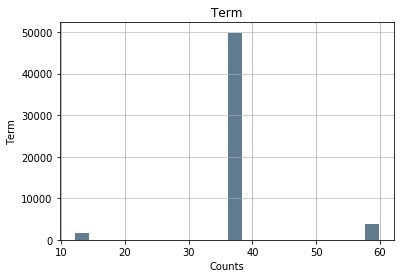

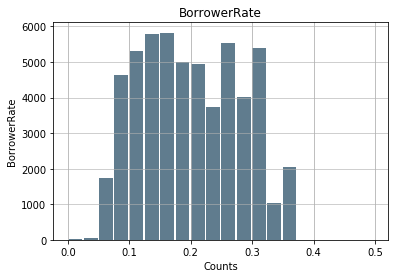

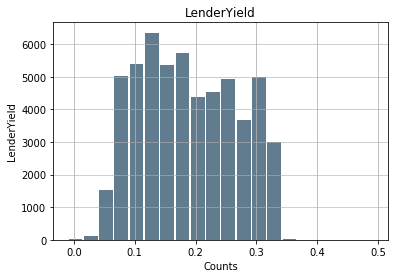

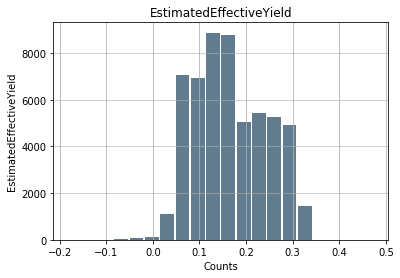

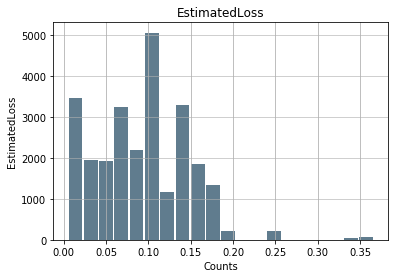

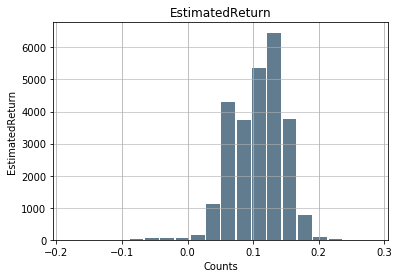

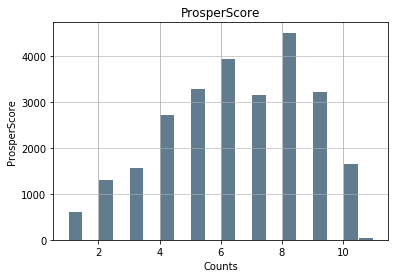

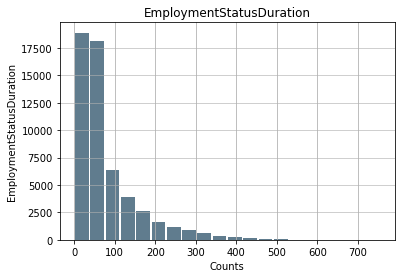

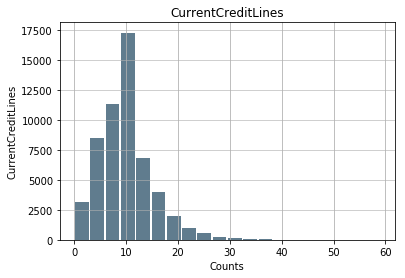

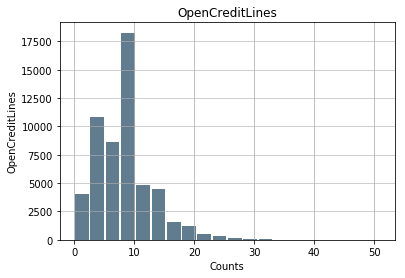

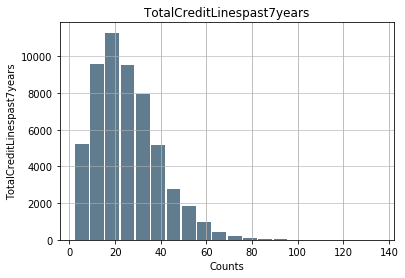

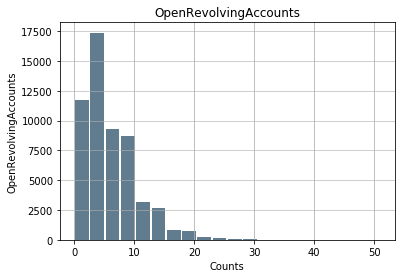

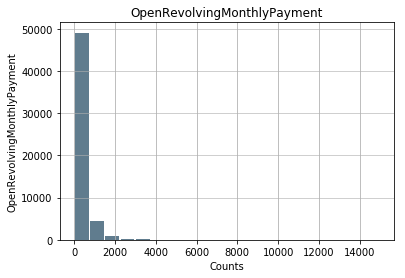

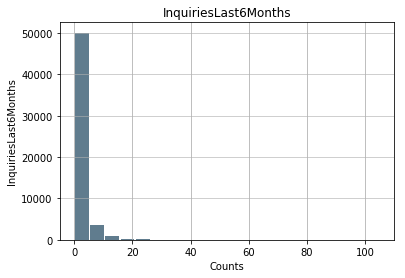

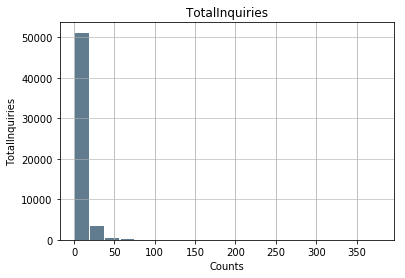

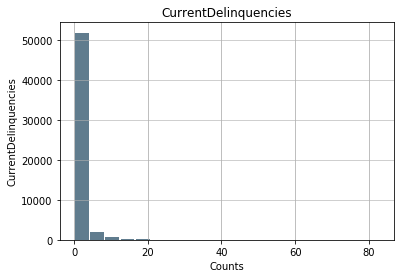

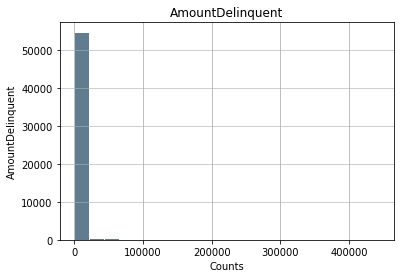

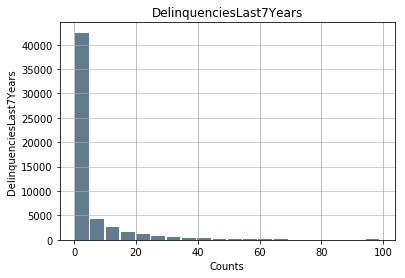

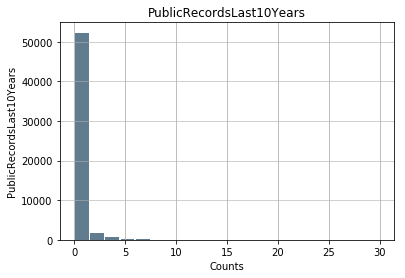

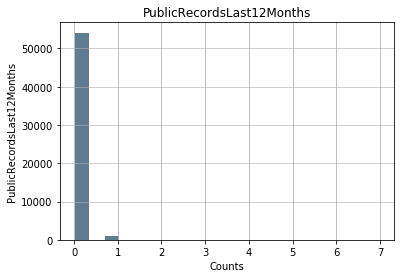

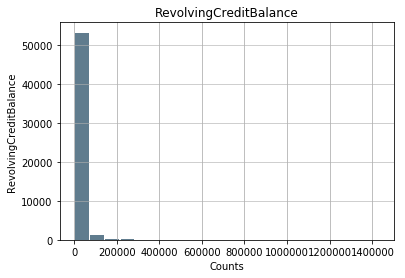

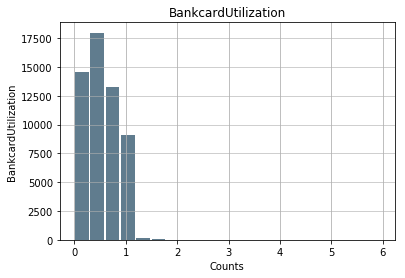

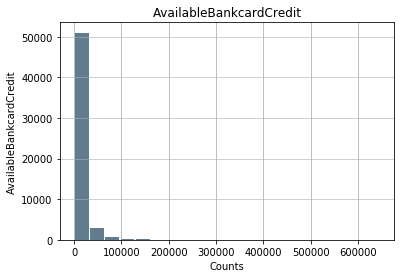

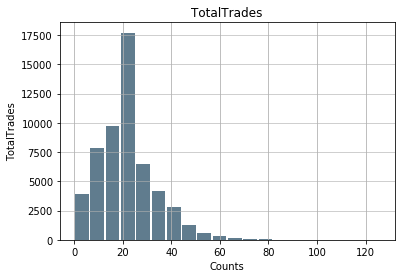

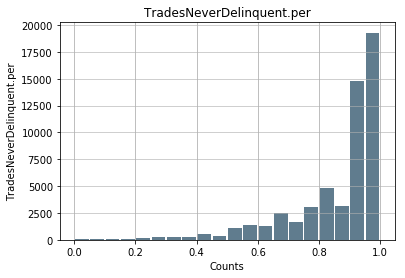

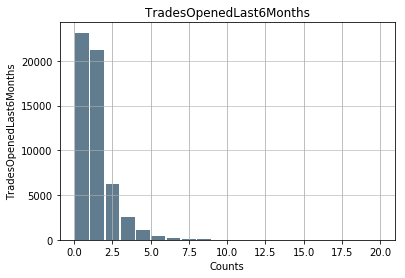

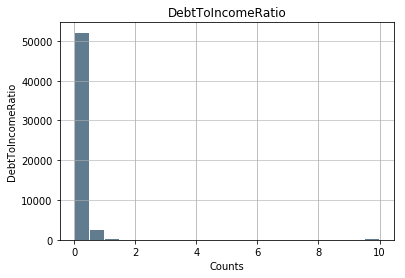

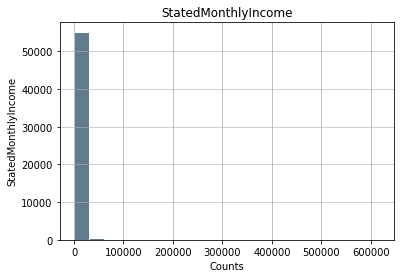

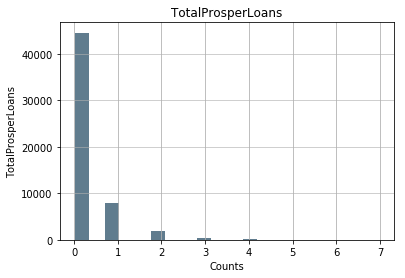

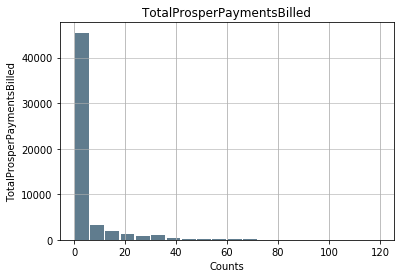

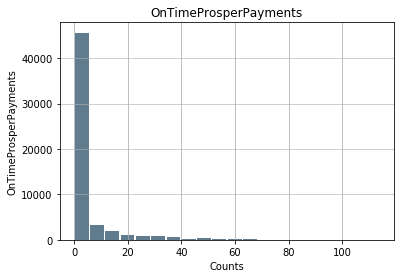

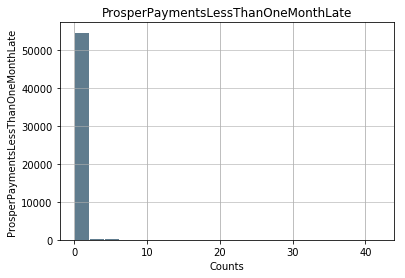

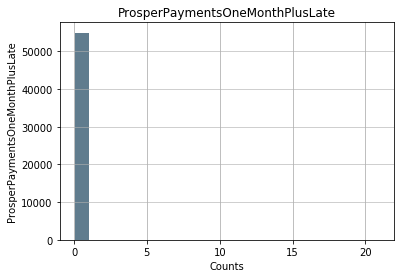

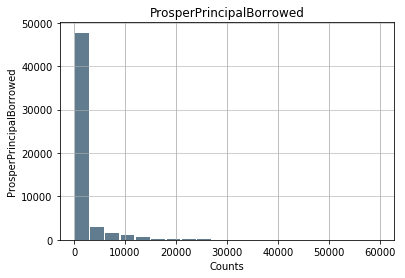

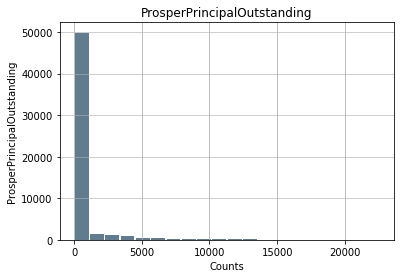

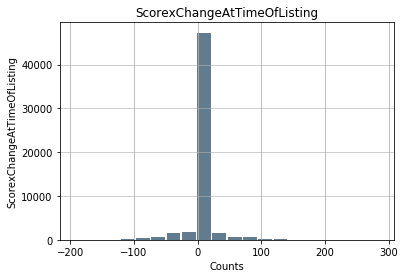

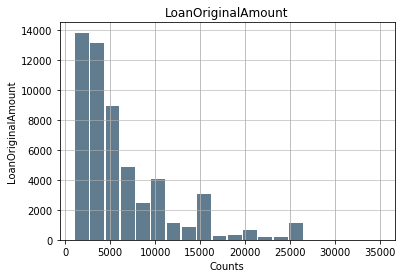

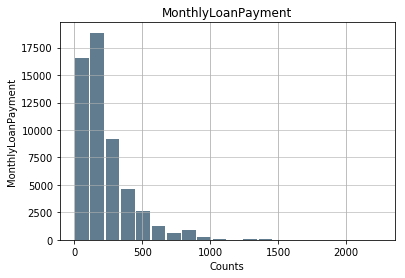

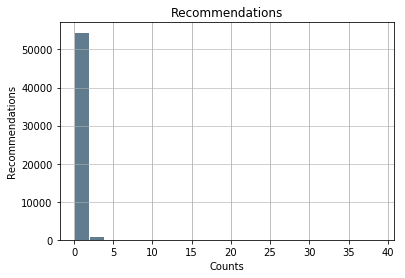

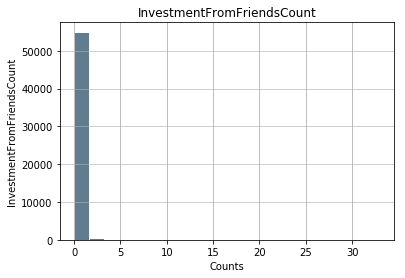

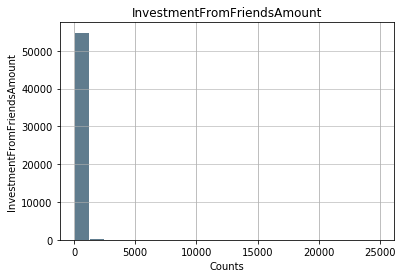

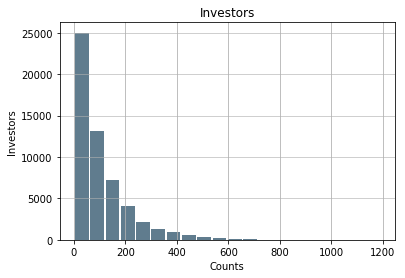

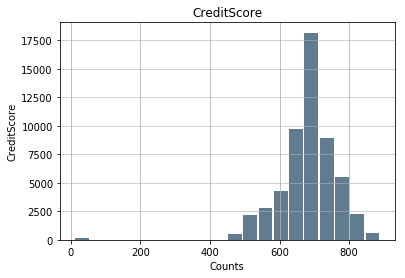

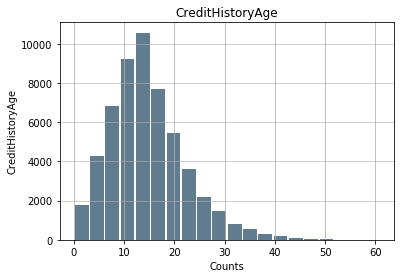

In [74]:
# Split the data into features and target label
completion = data["Completed.num"]
default = 1 - completion
features_raw = data.drop("Completed.num", axis = 1)

# Visualize continuous features of original data
continuous_features = ["Term", "BorrowerRate", "LenderYield", "EstimatedEffectiveYield", 
                       "EstimatedLoss", "EstimatedReturn", "ProsperScore", "EmploymentStatusDuration", 
                       "CurrentCreditLines", "OpenCreditLines", "TotalCreditLinespast7years", 
                       "OpenRevolvingAccounts", "OpenRevolvingMonthlyPayment", "InquiriesLast6Months",
                       "TotalInquiries", "CurrentDelinquencies", "AmountDelinquent", "DelinquenciesLast7Years",
                       "PublicRecordsLast10Years", "PublicRecordsLast12Months", "RevolvingCreditBalance",
                       "BankcardUtilization", "AvailableBankcardCredit", "TotalTrades", 
                       "TradesNeverDelinquent.per", "TradesOpenedLast6Months", "DebtToIncomeRatio", 
                       "StatedMonthlyIncome", "TotalProsperLoans", "TotalProsperPaymentsBilled", 
                       "OnTimeProsperPayments", "ProsperPaymentsLessThanOneMonthLate", 
                       "ProsperPaymentsOneMonthPlusLate", "ProsperPrincipalBorrowed", 
                       "ProsperPrincipalOutstanding", "ScorexChangeAtTimeOfListing", "LoanOriginalAmount",
                       "MonthlyLoanPayment", "Recommendations", "InvestmentFromFriendsCount", 
                       "InvestmentFromFriendsAmount", "Investors", "CreditScore", "CreditHistoryAge"]

for feature in continuous_features:
    size, scale = 1000, 10
    data[feature].plot.hist(grid=True, bins=20, rwidth=0.9, color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Below, I perform a log-transformation on those features I noted to be skewed, adding a small number to `x`, since the logarithm of 0 is undefined.

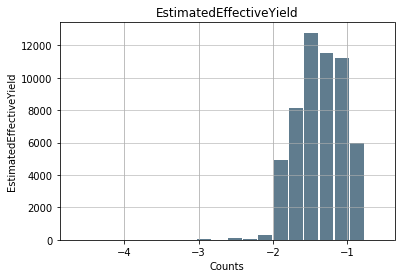

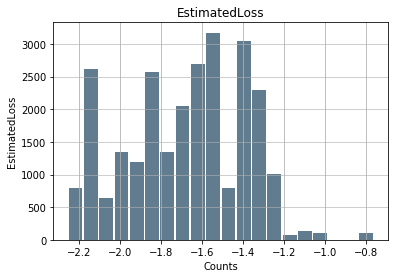

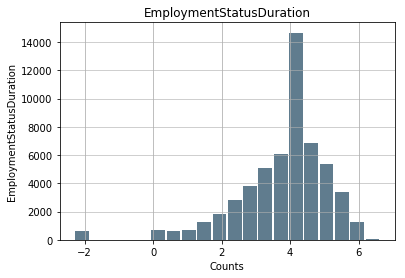

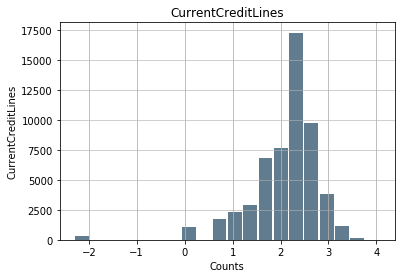

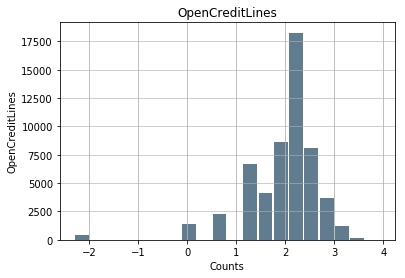

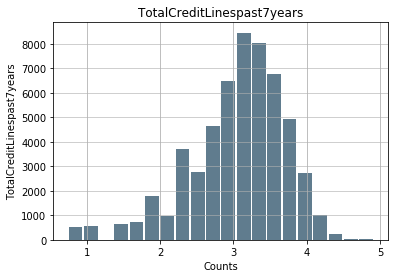

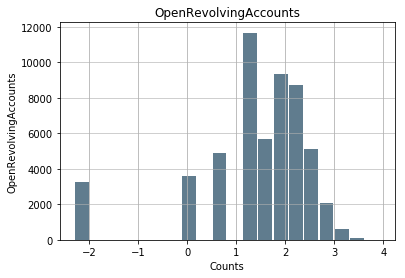

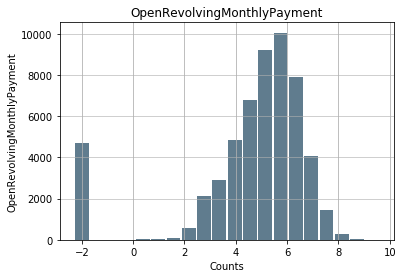

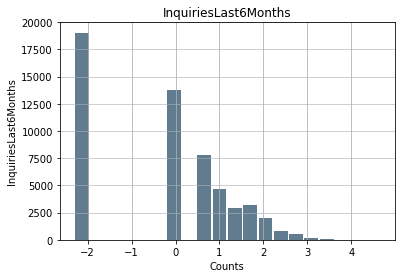

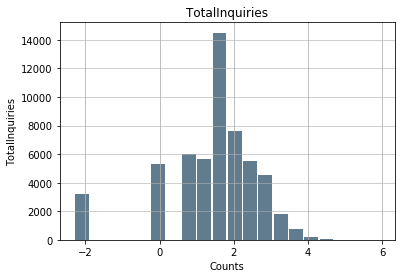

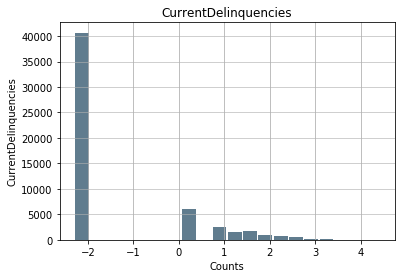

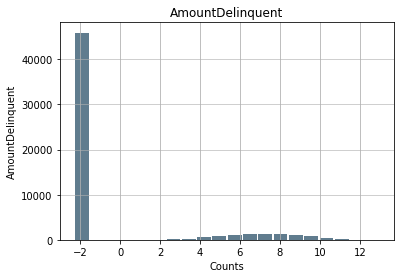

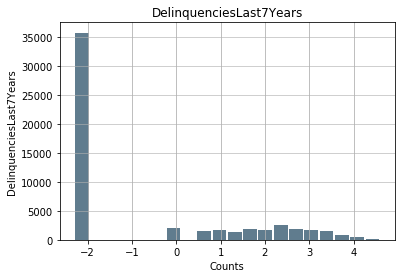

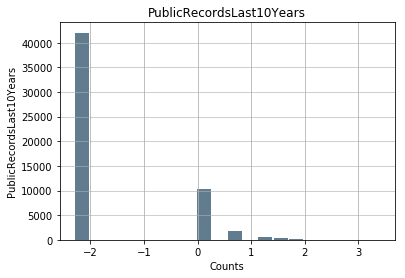

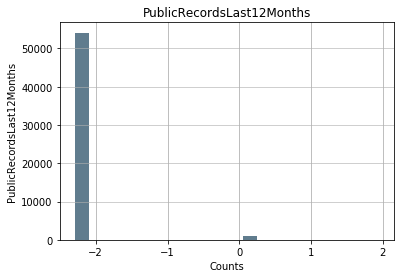

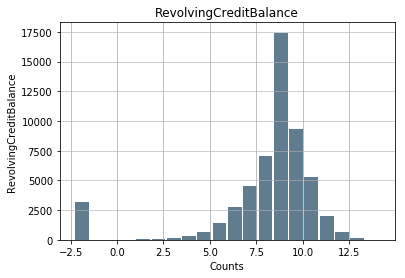

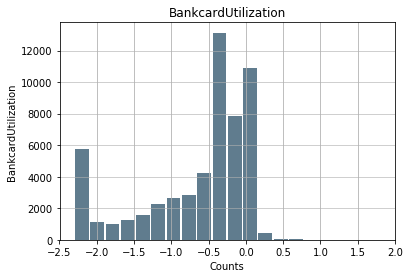

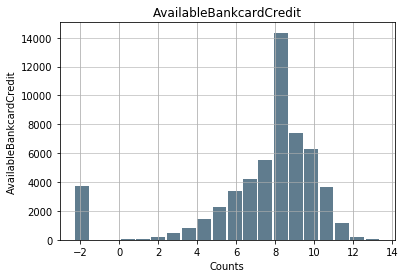

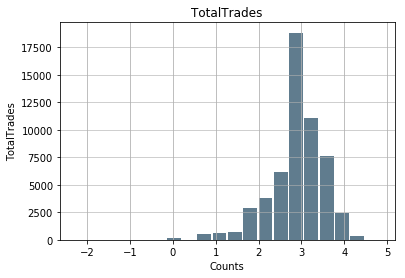

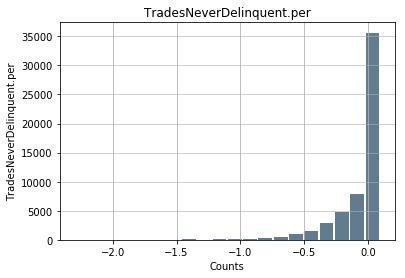

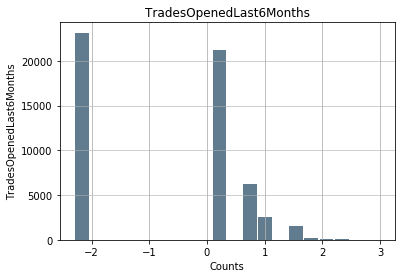

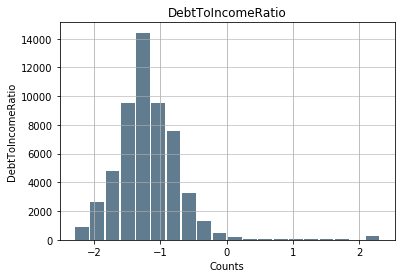

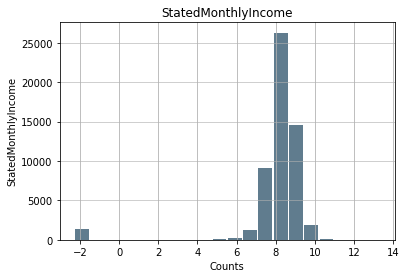

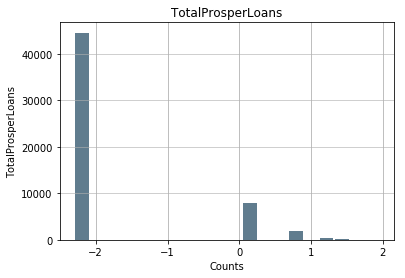

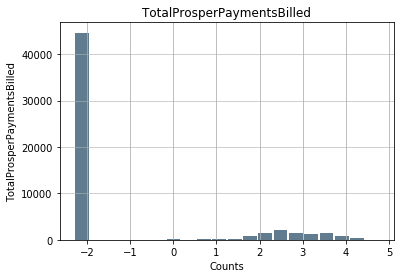

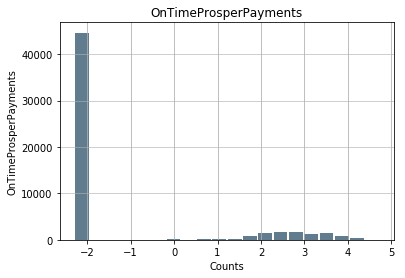

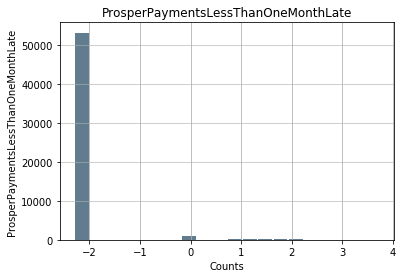

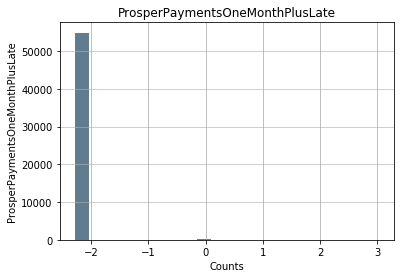

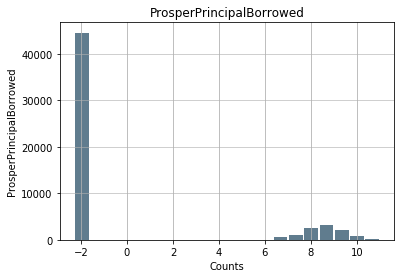

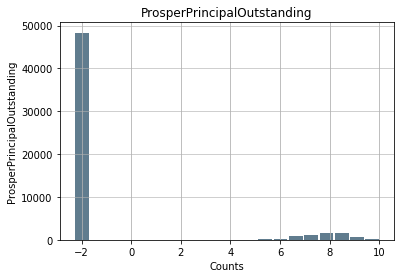

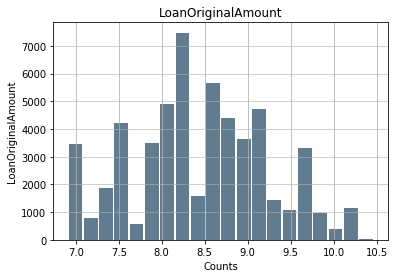

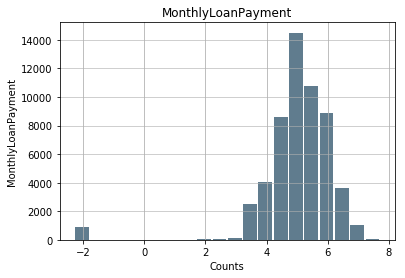

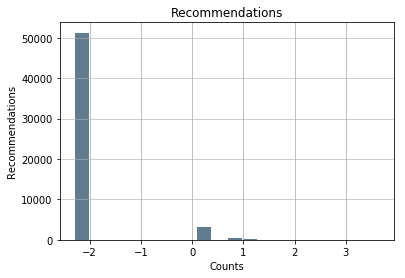

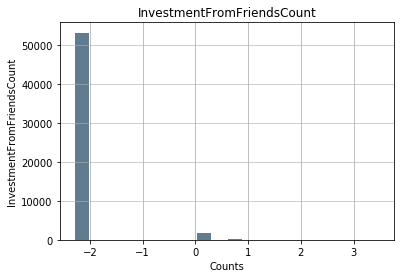

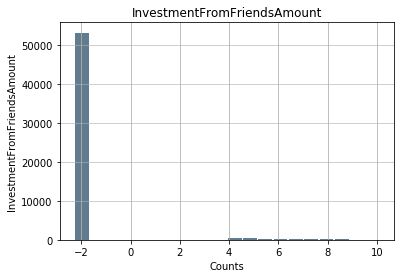

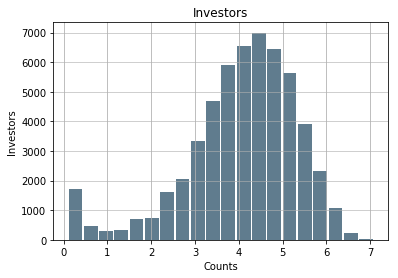

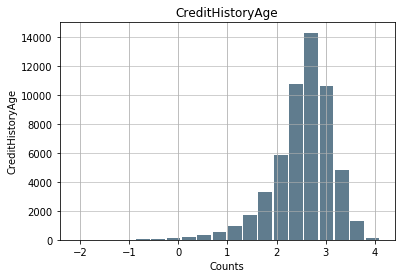

In [75]:
# Log-transform the skewed features
skewed = ['EstimatedEffectiveYield', 'EstimatedLoss', 'EmploymentStatusDuration', 'CurrentCreditLines',
          'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment',
          'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 
          'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months',
          'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades',
          'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'StatedMonthlyIncome',
          'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 
          'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed',
          'ProsperPrincipalOutstanding', 'LoanOriginalAmount', 'MonthlyLoanPayment', 'Recommendations',
          'InvestmentFromFriendsCount', 'InvestmentFromFriendsAmount', 'Investors', 'CreditHistoryAge']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 0.1))

# Visualize the new log distributions
for feature in skewed:
    size, scale = 1000, 10
    features_log_transformed[feature].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
    plt.title(feature)
    plt.xlabel('Counts')
    plt.ylabel(feature)
    plt.grid(axis='y', alpha=0.75)
    plt.show()

Many of the features are still not normally distributed, but their values are by and large less extreme, and less likely to affect learning algorithms.  In the future, I will explore other transformations that may be applied to non-normally-distributed features.

### Coding Categorical Data

Since many learning algorithms only take numerical input, below I dummy-code categorical variables, with `0` indicating the absence of a feature/feature category, and `1` indicating its presence.

In [76]:
features_log_transformed.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,ListingCategory,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,Rating,CreditScore,CreditHistoryAge
8487,1308268800000000000,36,0.1599,0.1499,-1.397153,-1.835711,0.08780,8.0,Debt,Employed,5.082025,False,1308268800000000000,2.493205,2.406945,3.299534,2.208274,5.420977,-2.302585,0.741937,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.217127,-0.798508,9.825910,3.261935,0.058269,-2.302585,-0.867501,True,8.927106,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,9.615812,1309910400000000000,6.267921,-2.302585,-2.302585,-2.302585,5.752890,B,769.5,3.173993
50808,1201910400000000000,36,0.0795,0.0795,-1.858541,NaN,NaN,NaN,Business,Full-time,4.920711,True,1201910400000000000,2.493205,2.493205,3.222868,2.091864,5.407620,0.095310,0.741937,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,9.737970,-1.139434,10.908725,3.139833,0.095310,0.095310,-1.427116,True,8.334896,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.517213,1202774400000000000,5.054142,-2.302585,-2.302585,-2.302585,4.906015,AA,829.5,2.236475
33821,1164672000000000000,36,0.2000,0.1950,-1.285906,NaN,NaN,NaN,Unknown,Not available,3.953165,False,1164499200000000000,2.208274,2.091864,2.646175,1.960095,5.204556,1.808289,3.000720,-2.302585,-2.302585,-2.302585,0.095310,-2.302585,8.711624,-0.415515,8.085056,3.000720,0.019803,0.095310,-1.832581,True,8.334896,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,7.495597,1165190400000000000,4.204543,-2.302585,-2.302585,-2.302585,2.312535,HR,529.5,2.424803
33105,1333324800000000000,36,0.1449,0.1349,-1.458435,-1.854699,0.07610,8.0,Debt,Employed,2.949688,False,1333324800000000000,1.960095,1.808289,2.572612,1.808289,5.124559,-2.302585,0.095310,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,8.838276,-0.274437,7.938124,2.572612,0.095310,-2.302585,-1.237874,True,7.824086,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.517213,1334016000000000000,5.148540,-2.302585,-2.302585,-2.302585,4.318821,B,669.5,1.819455
43147,1175385600000000000,36,0.2745,0.2445,-1.047254,NaN,NaN,NaN,Unknown,Full-time,3.095578,False,1175126400000000000,2.312535,2.091864,3.049273,0.741937,3.691376,3.095578,3.990834,0.095310,5.497578,1.960095,-2.302585,-2.302585,6.159307,0.039221,3.299534,2.778819,-0.478036,1.960095,-1.021651,True,8.334896,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,8.006401,1176681600000000000,4.814620,-2.302585,-2.302585,-2.302585,3.740048,HR,529.5,1.993115
13633,1385078400000000000,36,0.3059,0.2959,-0.996606,-1.337504,0.10663,3.0,Reno,Employed,5.142248,True,1385078400000000000,2.714695,2.493205,3.914021,1.808289,6.629495,-2.302585,1.131402,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,10.174625,-0.116534,8.745141,3.830813,0.067659,0.741937,-0.891598,True,8.740353,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,-2.302585,0.0,7.600952,1386201600000000000,4.450269,-2.302585,-2.302585,-2.302585,0.095310,HR,649.5,2.975040
6686,1341964800000000000,36,0.1679,0.1579,-1.365708,-1.8

Below, I dummy-code all categorical features:

In [77]:
# dummy-code the log-transformed features
features_final = pd.get_dummies(features_log_transformed)

# Print the number of features after dummy-coding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

print(encoded)

88 total features after one-hot encoding.
['ListingCreationDate', 'Term', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperScore', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'DateCreditPulled', 'CurrentCreditLines', 'OpenCreditLines', 'TotalCreditLinespast7years', 'OpenRevolvingAccounts', 'OpenRevolvingMonthlyPayment', 'InquiriesLast6Months', 'TotalInquiries', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'PublicRecordsLast10Years', 'PublicRecordsLast12Months', 'RevolvingCreditBalance', 'BankcardUtilization', 'AvailableBankcardCredit', 'TotalTrades', 'TradesNeverDelinquent.per', 'TradesOpenedLast6Months', 'DebtToIncomeRatio', 'IncomeVerifiable', 'StatedMonthlyIncome', 'TotalProsperLoans', 'TotalProsperPaymentsBilled', 'OnTimeProsperPayments', 'ProsperPaymentsLessThanOneMonthLate', 'ProsperPaymentsOneMonthPlusLate', 'ProsperPrincipalBorrowed', 'ProsperPrincipalOutstanding', 'ScorexChangeAtTimeOfListing

## Dimensionality Reduction

In this section, I use principal component analysis (PCA) to see if the features in my dataset can be reduced to fewer dimensions, which may improve algorithm performance, and reduce feature redundancy.

Below, I split the data into training and testing datasets.

In [78]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

X_train, X_test, y_train, y_test = train_test_split(features_final, completion, test_size=0.15, random_state=42)

### Normalizing Numerical Features

Prior to using PCA, I scale all numerical features, which ensures that algorithms treat features equally, rather than giving some undue weight.

In [79]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)

X_train_scaled = X_train
X_train_scaled[continuous_features] = scaler.fit_transform(X_train[continuous_features])

X_test_scaled = X_test
X_test_scaled[continuous_features] = scaler.fit_transform(X_test[continuous_features])

In [80]:
# Show the results of the split
print("Training set has {} samples.".format(X_train_scaled.shape[0]))
print("Testing set has {} samples.".format(X_test_scaled.shape[0]))

Training set has 46821 samples.
Testing set has 8263 samples.


Below, I drop all columns with remaining missing values, and save the data to a separate testing/training set which can be used with algorithms which handle missing data natively.

In [81]:
X_test_scaled.sample(10)

,ListingCreationDate,Term,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperScore,EmploymentStatusDuration,IsBorrowerHomeowner,DateCreditPulled,CurrentCreditLines,OpenCreditLines,TotalCreditLinespast7years,OpenRevolvingAccounts,OpenRevolvingMonthlyPayment,InquiriesLast6Months,TotalInquiries,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,PublicRecordsLast10Years,PublicRecordsLast12Months,RevolvingCreditBalance,BankcardUtilization,AvailableBankcardCredit,TotalTrades,TradesNeverDelinquent.per,TradesOpenedLast6Months,DebtToIncomeRatio,IncomeVerifiable,StatedMonthlyIncome,TotalProsperLoans,TotalProsperPaymentsBilled,OnTimeProsperPayments,ProsperPaymentsLessThanOneMonthLate,ProsperPaymentsOneMonthPlusLate,ProsperPrincipalBorrowed,ProsperPrincipalOutstanding,ScorexChangeAtTimeOfListing,LoanOriginalAmount,LoanOriginationDate,MonthlyLoanPayment,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors,CreditScore,CreditHistoryAge,ListingCategory_Auto,ListingCategory_Baby,ListingCategory_Boat,ListingCategory_Business,ListingCategory_Cosmetic,ListingCategory_Debt,ListingCategory_Engagement,ListingCategory_Green,ListingCategory_Household,ListingCategory_LargePurchase,ListingCategory_Medical,ListingCategory_Motorcycle,ListingCategory_Other,ListingCategory_Personal,ListingCategory_RV,ListingCategory_Reno,ListingCategory_Student,ListingCategory_Taxes,ListingCategory_Unknown,ListingCategory_Vacation,ListingCategory_Wedding,EmploymentStatus_Employed,EmploymentStatus_Full-time,EmploymentStatus_Not available,EmploymentStatus_Not employed,EmploymentStatus_Other,EmploymentStatus_Part-time,EmploymentStatus_Retired,EmploymentStatus_Self-employed,EmploymentStatus_Unknown,Rating_A,Rating_AA,Rating_B,Rating_C,Rating_D,Rating_E,Rating_HR,Rating_NC,Rating_Unknown
31827,1170374400000000000,0.5,0.416667,0.397260,0.812409,NaN,NaN,NaN,0.703012,False,1170028800000000000,0.712647,0.719050,0.096651,0.389594,0.000000,0.493566,0.450945,0.375739,0.000000,0.000000,0.634832,0.0,0.668349,0.459964,0.683569,0.625928,0.968511,0.500000,0.072891,True,0.587697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445977,0.000000,1171324800000000000,0.583850,0.0,0.0,0.0,0.381531,0.568182,0.750406,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
34448,1368489600000000000,0.5,0.481667,0.475068,0.844841,0.293094,0.573738,0.4,0.752741,True,1368489600000000000,0.712647,0.719050,0.801629,0.638817,0.656535,0.000000,0.416994,0.000000,0.000000,0.682668,0.500000,0.0,0.681575,0.577736,0.471888,0.665028,0.867194,0.500000,0.300317,True,0.672101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445977,0.584868,1368748800000000000,0.794349,0.0,0.0,0.0,0.610335,0.772727,0.745713,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
42238,1160611200000000000,0.5,0.250000,0.260274,0.724394,NaN,NaN,NaN,0.703012,False,1160438400000000000,0.712647,0.719050,0.625373,0.389594,0.426735,0.344649,0.571885,0.616098,0.000000,0.806603,0.716042,0.0,0.668349,0.459964,0.683569,0.625928,0.968511,0.500000,0.825608,True,0.498190,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445977,0.438244,1161129600000000000,0.731935,0.0,0.0,0.0,0.000000,0.545455,0.748990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
43413,1211155200000000000,0.5,0.547222,0.539726,0.866330,NaN,NaN,NaN,0.547867,False,1209945600000000000,0.649456,0.561892,0.302303,0.557931,0.426735,0.000000,0.499190,0.000000,0.000000,0.000000,0.000000,0.0,0.574861,0.318900,0.566407,0.401740,1.000000,0.634832,0.230651,True,0.621653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.445977,0.566716,1211932800000000000,0.791166,0.0,0.0,0.0,0.694266,0.750000,0.528159,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
14311,1321401600000000000,0.5,0.490000,0.483288,0.855787,0.281010,0.602081,0.7,0.899029,True,1321401600000000000,0.694256,0.719050,0.534539,0.557931,0.620927,0.000000,0.291180,0.375739,0.000000,0.727277,0.000000,0.0,0.633275,0.415524,0.698836,0.59

In [82]:
X_train_non_na = X_train_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                      'EstimatedReturn', 'ProsperScore'], axis=1)
X_test_non_na = X_test_scaled.drop(['EstimatedEffectiveYield', 'EstimatedLoss',
                                    'EstimatedReturn', 'ProsperScore'], axis=1)

X_train_full = X_train_scaled
X_test_full = X_test_scaled

### Applying Dimensionality Reduction

Below, I reduce the features to 10 components, and then 3 components.  I further reduce the dataset to the top 30% of most important features (those that account for the most variance), and to the top 10%.  All are saved to separate testing/training sets.

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10, random_state=42)
pca.fit(X_train_non_na)

X_train_pca10 = pca.transform(X_train_non_na)
X_test_pca10 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05, 2.80739588e-35,
       2.24526551e-35, 1.80332701e-35, 1.50397138e-35, 1.47234153e-35,
       1.30534416e-35, 1.12288385e-35])

In [84]:
pca = PCA(n_components=3, random_state=42)
pca.fit(X_train_non_na)

X_train_pca3 = pca.transform(X_train_non_na)
X_test_pca3 = pca.transform(X_test_non_na)

pca.explained_variance_ratio_

array([9.99553652e-01, 4.25776825e-04, 2.05712758e-05])

In [85]:
from sklearn.feature_selection import SelectPercentile

X_train_reduce30 = SelectPercentile(percentile=30).fit_transform(X_train_non_na, y_train)
X_test_reduce30 = SelectPercentile(percentile=30).fit_transform(X_test_non_na, y_test)

X_train_reduce10 = SelectPercentile(percentile=10).fit_transform(X_train_non_na, y_train)
X_test_reduce10 = SelectPercentile(percentile=10).fit_transform(X_test_non_na, y_test)

Above, it looks like the most important three features account for quite a bit of the variance, and the rest account for comparatively tiny portions.  This may make the use of a highly reduced dataset feasible.

----
## Evaluating Model Performance


### The Naive Predictor

Below, we look at how a simple model, which always predicts that a loan is repaid, performs.  Although the accuracy and F-score in this case is rather high, it is clear that this model performs rather poorly.  An improved model must have higher precision -- which denotes how many of the loans identified as repaid were, in fact, repaid -- even if at the expense of recall, particularly given that lenders should be more wary of investing in loans unlikely to pay off, even if this involves risk of not investing in potentially high-yield loans.

In [86]:
# true positives
TP = np.sum(completion)
# false positives
FP = completion.count() - TP

# true negatives
TN = 0
# false negatives
FN = 0

# accuracy, precision and recall
accuracy = TP/(TP+FP)
recall = TP/(TP+FN)
precision = TP/(TP+FP)

# F-score for beta = 1
fscore = (1+1**2) * (precision * recall)/(1**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}, Precision: {:.4f}, Recall: {:.4f}]".format(accuracy, fscore, precision, recall))

Naive Predictor: [Accuracy score: 0.6912, F-score: 0.8174, Precision: 0.6912, Recall: 1.0000]


## Model Application


I picked three Ensemble methods commonly used for the task of classification - one averaging method (random forests), and two boosting methods.  I also picked Logistic Regression, as having an output of probabilities allows for more interpretability, and flexibility after the fact in setting thresholds for decisions.  I broadly retain some of my previous descriptions of these model types, where I have previously used them.

For strengths and weaknesses of the relevant models, I primarily consulted the following sources, keeping in mind that heuristics do not necessarily apply to each data set:

https://medium.com/@randylaosat/machine-learning-whats-inside-the-box-861f5c7e72a3

https://medium.com/@vijaya.beeravalli/comparison-of-machine-learning-classification-models-for-credit-card-default-data-c3cf805c9a5a

https://www.dummies.com/programming/big-data/data-science/machine-learning-dummies-cheat-sheet/

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c

https://medium.com/@grohith327/gradient-boosting-and-xgboost-90862daa6c77

#### Ensemble Methods: Random Forest

The strengths of this model, which averages across multiple decision trees, are the following: it natively handles categorical variables; it is less prone to overfitting than a single decision tree -- therefore, it is more likely to select relevant features; and it frequently outperforms other methods on accuracy.  **These features make this model a good candidate for this problem, which has numerous categorical and continuous features.  Given that after one-hot conversion, there were 88 total features, a model which will automatically select the most important features is of particular importance.**  Additionally, it can handle imbalanced data, which applies to this dataset, and is a flexible algorithm that does not require a lot of parameter tuning.

The weaknesses of this model are that it doesn't tend to perform well with a bad set of features; it's not very transparent, and it's hard to interpret what's going on in the algorithm. Further, too many trees can slow down the algorithm.

#### Ensemble Methods: AdaBoost

AdaBoost is particularly well-suited for boosting the performance of decision trees on binary classification tasks.  It typically does not overfit despite excellent accuracy (although it is to date unclear exactly how), and frequently outperforms other methods.  **These features make it a good model to attempt for this problem, given that the algorithm can be used to boost the performance of classifiers that work well natively with categorical data, such as decision trees, and like random forests will automatically select those features that are most important.**  It additionally does not require variable transformation, and has relatively few parameters that need tweaking.

The weaknesses of this model are that it does not deal well with noisy data, and the efficiency of the algorithm is affected by outliers, since the algorithm attempts to fit each point.

#### Logistic Regression

The strengths of this model are that it's fairly easy to interpret in terms of probabilities; relatively unlikely to overfit; fast; well-suited for binary classification tasks; and explanatory variables can be continuous or categorical.  **These features, and in particular the fact that results are probabilities, make this model a good candidate for this problem, since probabilities allow for post-hoc adjustment of the threshold for whether a lender should fund a particular loan, perhaps depending on their personal finances or risk aversion.**

The downsides of this model are that it's not particularly good at capturing complex or non-linear relationships between features, or dealing with multiple/non-linear decision boundaries; generally, it's not very flexible.

#### Ensemble Methods: XGBoost

XGBoost, recommended by a reviewer, is highly robust to irregularities in data, and like AdaBoost, is a boosting algorithm which tries to create a strong classifier from a series of weaker classifiers.  It additionally natively handles missing data.  **Given that the dataset I have is quite noisy, with quite a bit of missing or imputed data, and is particularly suited to decision trees, this algorithm would be appropriate to try.**

### Training and Predicting Pipeline

Below I use a training function adapted from another Udacity project to evaluate the peformance of the various classifiers, with repect to time and various metrics, on testing and training data.

In [87]:
from sklearn.metrics import fbeta_score, accuracy_score, f1_score, precision_score, recall_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    results['pred_time'] = end - start
            
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train[:300])
        
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    results['f_train'] = f1_score(y_train[:300], predictions_train[:300])
        
    results['f_test'] = f1_score(y_test, predictions_test)
    
    results['p_train'] = precision_score(y_train[:300], predictions_train[:300])
        
    results['p_test'] = precision_score(y_test, predictions_test)
    
    results['r_train'] = recall_score(y_train[:300], predictions_train[:300])
        
    results['r_test'] = recall_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    return results

### Model Evaluation


#### Full dataset without missing data

In [88]:
from time import time

clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_non_na = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_non_na[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_non_na[clf_name][i] = \
        train_predict(clf, samples, X_train_non_na, y_train, X_test_non_na, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


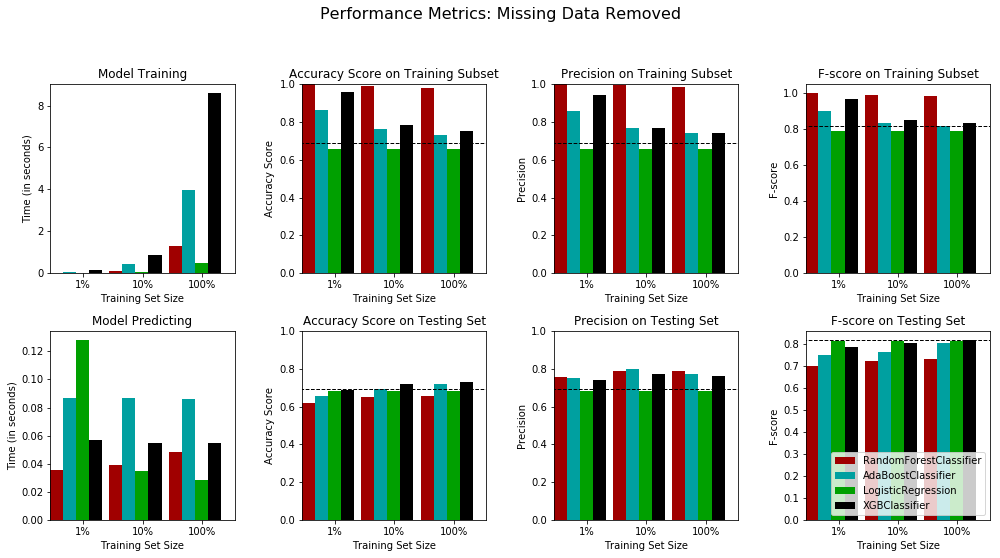

In [89]:
vs.evaluate(results_non_na, accuracy, precision, fscore, "Performance Metrics: Missing Data Removed")

#### PCA: 10 most important features

In [90]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca10[clf_name][i] = \
        train_predict(clf, samples, X_train_pca10, y_train, X_test_pca10, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


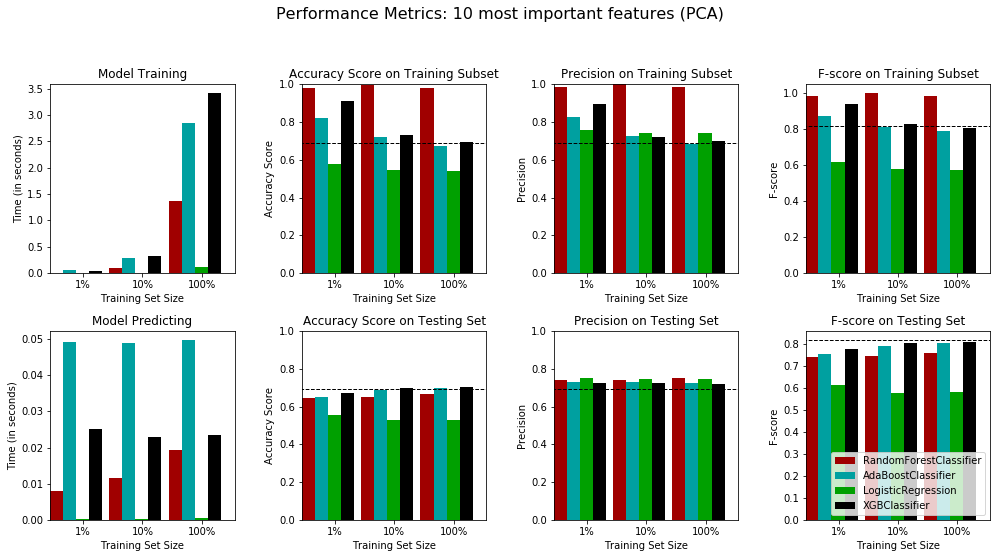

In [91]:
vs.evaluate(results_pca10, accuracy, precision, fscore, "Performance Metrics: 10 most important features (PCA)")

#### PCA: 3 most important features

In [92]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_pca3 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_pca3[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_pca3[clf_name][i] = \
        train_predict(clf, samples, X_train_pca3, y_train, X_test_pca3, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


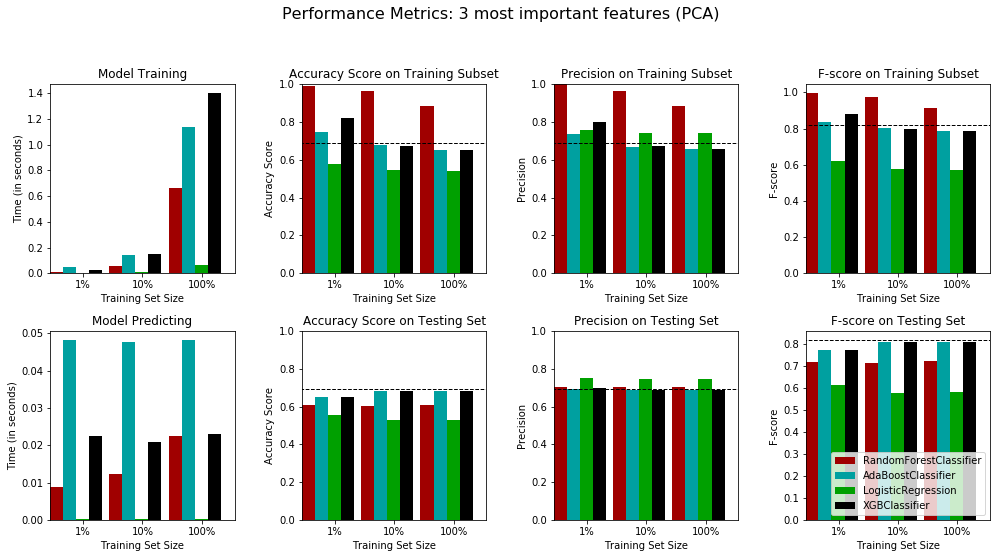

In [93]:
vs.evaluate(results_pca3, accuracy, precision, fscore, "Performance Metrics: 3 most important features (PCA)")

#### PCA: top 30% of features

In [94]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce30 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce30[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce30[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce30, y_train, X_test_reduce30, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


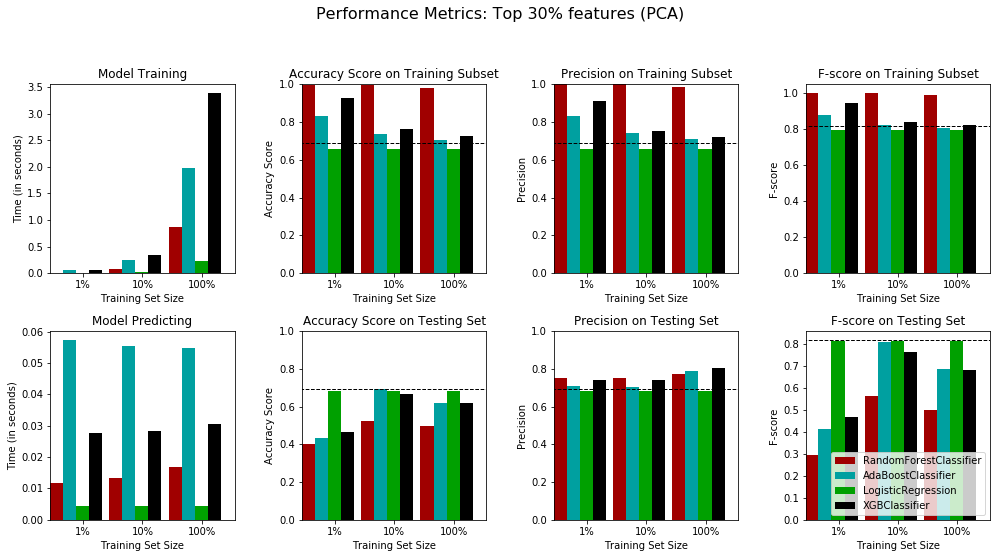

In [95]:
vs.evaluate(results_reduce30, accuracy, precision, fscore, "Performance Metrics: Top 30% features (PCA)")

#### PCA: top 10% of features

In [96]:
clf_A = RandomForestClassifier(random_state = 42)
clf_B = AdaBoostClassifier(random_state = 42)
clf_C = LogisticRegression(random_state = 42)
clf_D = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_reduce10 = {}
for clf in [clf_A, clf_B, clf_C, clf_D]:
    clf_name = clf.__class__.__name__
    results_reduce10[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_reduce10[clf_name][i] = \
        train_predict(clf, samples, X_train_reduce10, y_train, X_test_reduce10, y_test)

RandomForestClassifier trained on 468 samples.
RandomForestClassifier trained on 4682 samples.
RandomForestClassifier trained on 46821 samples.
AdaBoostClassifier trained on 468 samples.
AdaBoostClassifier trained on 4682 samples.
AdaBoostClassifier trained on 46821 samples.
LogisticRegression trained on 468 samples.
LogisticRegression trained on 4682 samples.
LogisticRegression trained on 46821 samples.
XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


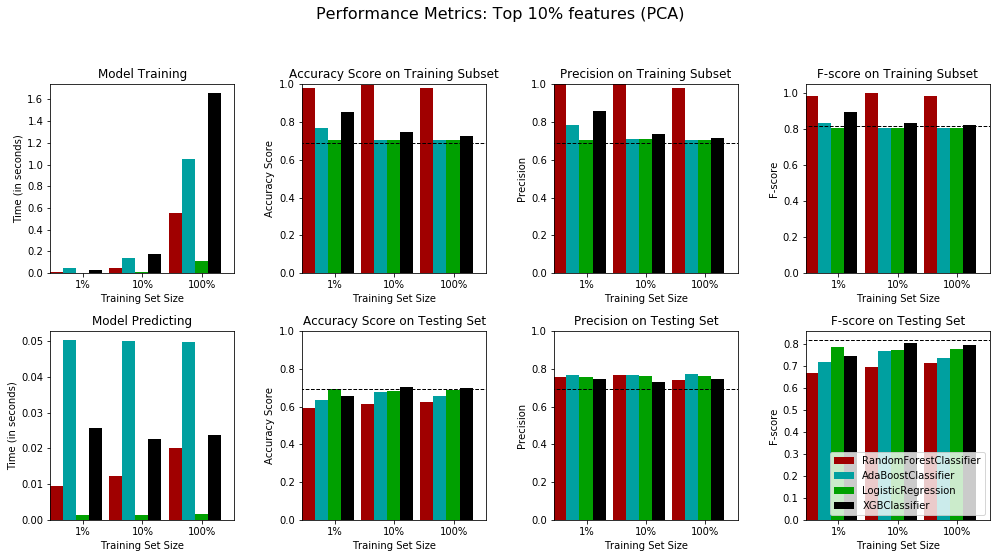

In [97]:
vs.evaluate(results_reduce10, accuracy, precision, fscore, "Performance Metrics: Top 10% features (PCA)")

#### Full dataset with missing data (XGBoost only, which unlike AdaBoost handles missing values)

In [98]:
clf_A = XGBClassifier(random_state = 42)

samples_100 = len(y_train)
samples_10 = int(samples_100 * 0.1)
samples_1 = int(samples_100 * 0.01)

results_full = {}
for clf in [clf_A]:
    clf_name = clf.__class__.__name__
    results_full[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results_full[clf_name][i] = \
        train_predict(clf, samples, X_train_full, y_train, X_test_full, y_test)

XGBClassifier trained on 468 samples.
XGBClassifier trained on 4682 samples.
XGBClassifier trained on 46821 samples.


In [99]:
results_spliced = results_non_na
results_spliced["XGBClassifier_full"] = results_full["XGBClassifier"]

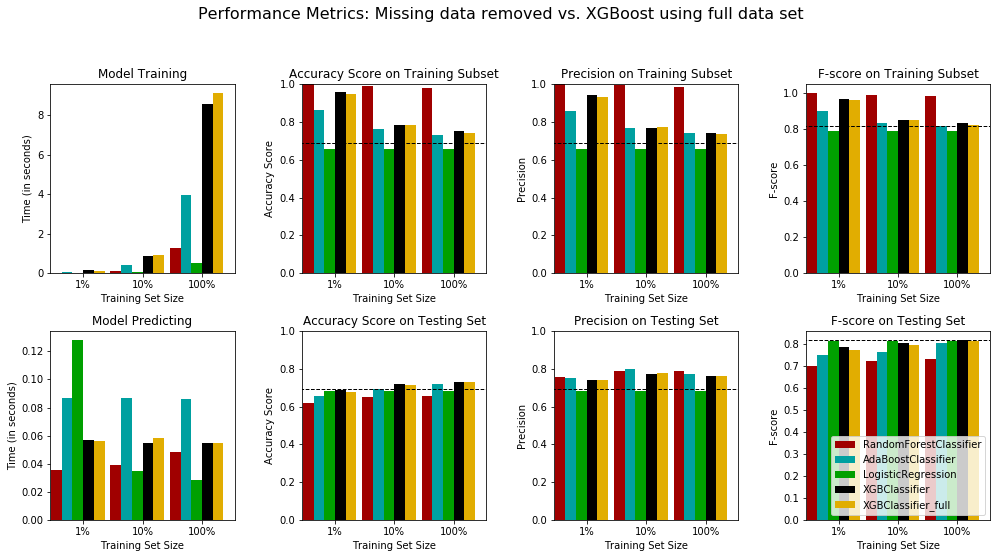

In [100]:
vs.evaluate5(results_spliced, accuracy, precision, fscore, "Performance Metrics: Missing data removed vs. XGBoost using full data set")

----
## Optimizing Results

**As can be seen, the Random Forest model tends to overfit the training data, and then perform similar to other models on precision in testing, or underperform significantly on other measures.  It therefore appears comparatively unsuited to this task.  Logistic Regression tends to perform similarly to other models or underperform on precision, and performs moderately to significantly worse on other measures.  It rarely performs better than the naive classifier, and when it does, its performance is similar to that of other methods.  It therefore appears similarly unsuited, and its performance suffers significantly when the features are reduced to several dimensions.  In contrast, the boosting methods have a less pronounced tendency to overfit the data than the Random Forest method, show similar performance on precision, and higher performance on other measures (accuracy and f-score).  Although they are slower to train, they appear to be roughly comparable in testing, with XGBoost having an edge over AdaBoost.**

**AdaBoost and XGBoost perform roughly similarly on the testing and training data, with XGBoost perhaps having a slight edge in testing (no improvement on measures is seen from including the variables with missing data, in the latter case).  Performance appears to be best all-around (precision higher than naive; F1 metric no lower than naive) when all available features are used.  Both algorithms are similarly well-suited for the large number of continuous and categorical variables, as seen in this dataset, given that ensemble methods will pick out the most important features, and decision tree-based classifiers are paticularly well-suited to categorical data.  It is difficult to choose between the two methods based on the above results; I will therefore attempt to optimize both models.  Below, I briefly discuss how the two methods work.**

### AdaBoost

**AdaBoost takes a family of weak classifiers, which may perform only slightly better than chance at correctly classifying any given point, combines them, and lets them 'vote' on the correct category of any given point.  When a large number of such weak classifiers vote on any given point, the chance that this point will be correctly classified increases significantly.  By default, AdaBoost uses decision tree classifiers to classify points, although it can use different base classifiers.  The process of classifying points continues either until each point is correctly classified in a labeled data set, or until the maximum number of iterations specified is reached.**

**The image below illustrates this: a weak classifier in Box 1 classifies several of the positive points correctly, but misclassifies the rest of the positive points.  The weights of the misclassified samples are then increased, and the next weak classifier (Box 2) is more likely to classify these points correctly.  The weights of misclassified samples is increased again, and the process repeats.  In the end, the weak classifiers are combined, and 'vote' on the category a given point belongs to:**

![Boosting](boosting.png)

**The drawback of this method, as mentioned, is that it does not deal well with noisy data, given that it attempts to categorize all points correctly.  It is not, however, prone to overfitting, although the reason for this is not clear.**

Resources:

https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c (image copied from this resource)

### XGBoost

**XGBoost is a gradient boosting algorithm, which like AdaBoost attempts to create a strong learner from a group of weak learners, giving increased weight to previously misclassified outcomes, and lower weight to correctly classified outcomes.  Where it differs is that in gradient boosting, new learners work to reduce the residuals of previous learners, thus minimizing loss.  It further penalizes excessive complexity in decision trees, and has a randomization parameter which can reduce the correlation between trees.**

**The process of iteratively reducing residuals can be thus visualized, with error virtually eliminated by the 20th iteration:**

![XGB1](xgb1.png)

![XGB2](xgb2.png)

![XGB3](xgb3.png)

Resources:

https://hackernoon.com/gradient-boosting-and-xgboost-90862daa6c77 (remaining images copied from this source)
https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
https://www.datacamp.com/community/tutorials/xgboost-in-python
https://medium.com/syncedreview/tree-boosting-with-xgboost-why-does-xgboost-win-every-machine-learning-competition-ca8034c0b283

### Model Tuning (AdaBoost)

In [101]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

clf = AdaBoostClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 500, 1000], 
                  learning_rate=[0.01, 0.1, 0.5, 1],
                  algorithm=['SAMME', 'SAMME.R'])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision', verbose=5)

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_adaboost_clf = grid_fit.best_estimator_

adaboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_adaboost_predictions = best_adaboost_clf.predict(X_test_non_na)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 42.2min finished


In [102]:
best_adaboost_clf.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1,
 'n_estimators': 1000,
 'random_state': 42}

In [103]:
print("Unoptimized Model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, adaboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_adaboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_adaboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_adaboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_adaboost_predictions)))

Unoptimized Model
------
Accuracy score on testing data: 0.7217
F-score on testing data: 0.8051
Precision on testing data: 0.7725
Recall on testing data: 0.8406

Optimized Model
------
Final accuracy score on the testing data: 0.6898
Final F-score on the testing data: 0.7609
Final precision on the testing data: 0.8047
Final recall on the testing data: 0.7217


### Model Tuning (XGBoost)

In [109]:
clf = XGBClassifier(random_state=42)

parameters = dict(n_estimators=[10, 50, 100, 500, 1000], 
                  learning_rate=[0.01, 0.1, 0.5, 1], 
                  max_depth=[3,6,9])

scorer = {'F1': make_scorer(f1_score), 
          'Precision': make_scorer(precision_score), 
          'Recall': make_scorer(recall_score)}

grid_obj = GridSearchCV(clf, param_grid = parameters, scoring=scorer, refit='Precision', verbose=5)

grid_fit = grid_obj.fit(X_train_non_na, y_train)

best_xgboost_clf = grid_fit.best_estimator_

xgboost_predictions = (clf.fit(X_train_non_na, y_train)).predict(X_test_non_na)
best_xgboost_predictions = best_xgboost_clf.predict(X_test_non_na)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 180 out of 180 | elapsed: 121.9min finished


In [ ]:
best_xgboost_clf.get_params()

ERROR! Session/line number was not unique in database. History logging moved to new session 192


In [ ]:
print("Unoptimized Model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, xgboost_predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Final precision on the testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Final recall on the testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))

### Final Model Evaluation



#### Results:

|     Metric     | Naive Predictor   | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :---------------: | :-------------: | 
| Accuracy Score | 0.6912            | 0.7217            |   0.6898        |
| F-score        | 0.8174            | 0.8051            |   0.7609        |
| Precision      | 0.6912            | 0.7725            |   0.8047        |
| Recall         | 1.0000            | 0.8406            |   0.7217        |

**Here it can be seen that although accuracy and recall are lower in the optimized model than in the unoptimized model, or the naive predictor, precision is higher, which should assist lenders in avoiding those loans most likely to default.**

----
## Feature Importance

### Extracting Feature Importance

Below, I plot the most important features for the optimal model chosen above.  As can be seen, the magnitude of the monthly loan payment, the age of credit history, the amoung of revolving credit balance, the loan borrower rate, and the loan origination date are the best predictors of whether a loan will default, or not.  The first four predictors tend to correlate with a borrower's credit worthiness, and it is unsurprising that they primarily determine whether a loan will be paid back, or not.  In contrast, it is unclear why loan origination date should be a good predictor of a loan defaulting -- however, I have previously found that loan completion and lender profit tend to 'cycle' over time, for reasons that would need to be expored further:

https://eskrav.github.io/udacity-data-analyst/explore-and-summarize/explore-and-summarize.html#lender_profit_by_loan_origination_quarter

In [ ]:
model = best_adaboost_clf.fit(X_train_non_na, y_train)

importances_adaboost = best_adaboost_clf.feature_importances_

vs.feature_plot(importances_adaboost, X_train_non_na, y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 181


In [ ]:
model = best_xgboost_clf.fit(X_train_non_na, y_train)

importances_xgboost = best_xgboost_clf.feature_importances_

vs.feature_plot(importances_xgboost, X_train_non_na, y_train)

ERROR! Session/line number was not unique in database. History logging moved to new session 182


### Feature Selection

Here, I look at how a model performs if only the five most important features are used.  Accuracy, f-score, and recall suffer, but predicion here arguably the most important metric, suffers only marginally.  With further exploration, it is possible that a model utilising only the most important features would show adequate performance in production.

In [ ]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train_non_na[X_train_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test_non_na[X_test_non_na.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
adaboost_clf = (clone(best_adaboost_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_adaboost_predictions = adaboost_clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, best_adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, best_adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, best_adaboost_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_adaboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_adaboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, reduced_adaboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, reduced_adaboost_predictions)))

ERROR! Session/line number was not unique in database. History logging moved to new session 183


In [ ]:
# Train on the "best" model found from grid search earlier
xgboost_clf = (clone(best_xgboost_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_xgboost_predictions = xgboost_clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, best_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, best_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, best_xgboost_predictions)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_xgboost_predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, reduced_xgboost_predictions)))
print("Precision on testing data: {:.4f}".format(precision_score(y_test, reduced_xgboost_predictions)))
print("Recall on testing data: {:.4f}".format(recall_score(y_test, reduced_xgboost_predictions)))

ERROR! Session/line number was not unique in database. History logging moved to new session 184


In [ ]:
from xgboost import plot_tree

plot_tree(best_xgboost_clf, rankdir='LR')
plt.show()

ERROR! Session/line number was not unique in database. History logging moved to new session 186
ERROR! Session/line number was not unique in database. History logging moved to new session 187


In [ ]:
import dill
dill.dump_session('notebook_env.db')